In [1]:
import matplotlib
matplotlib.use('Agg')

import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
from scipy.interpolate import griddata

import h5py

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["DejaVu Serif"]})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_5726/3131495678.py:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [3]:
vol_func = lambda rm,rp,thetam,thetap,phim,phip: \
            1.0/3.0*(rp**3-rm**3) * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
rarea_func = lambda r,thetam,thetap, phim, phip: \
           r**2.0 * abs(np.cos(thetam)-np.cos(thetap)) * (phip-phim)
tarea_func = lambda rm, rp, theta, phim, phip: \
          0.5*(rp**2.0 - rm**2.0)*np.sin(theta)*(phip - phim)
parea_func = lambda rm, rp, thetam, thetap: \
          0.5*(rp**2.0 - rm**2.0)*abs(thetap - thetam)

In [4]:
def PlotProfile(datax, datay, xmin, xmax, ymin, ymax,  ylabel, label1, filename, xlabel='$r/r_g$', logscale=0, 
                xlogscale=0, datax1_2=None, datay1_2=None, datay1_3=None, datax2=None, datay2=None, datax2_2=None, 
                datay2_2=None, datay2_3=None, datax3=None, datay3=None, datax3_2=None, datay3_2=None, datay3_3=None, 
                datax4=None, datay4=None, datax4_2=None, datay4_2=None, datax5=None, datay5=None, label2='', 
                label3='', label4='', label5='',title=None,leg_loc=None,text=None,text_loc=None):
    plots, axes = plt.subplots(figsize=(9,9),dpi=300)
    plt.xlabel(xlabel, size = 30)
    plt.ylabel(ylabel, size = 30)
    plt.subplots_adjust(left=0.15,right=0.88,top=0.9,bottom=0.1)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    if logscale > 0:
        axes.set_yscale('log')
    if xlogscale > 0:
        axes.set_xscale('log')
    if title is not None:
        plt.title(title,size=20)

    plt.plot(datax,datay,color='black',label=label1,linewidth=3.0,linestyle='dashed')
    if datay1_2 is not None:
        if datax1_2 is not None:
            plt.scatter(datax1_2,datay1_2,s=80,facecolors='none', edgecolors='black')
        else:
            plt.scatter(datax1,datay1_2,s=80,facecolors='none', edgecolors='black')    
    if datay1_3 is not None:
        plt.plot(datax,datay1_3,color='black',linestyle='dashed',linewidth=4.0)
    if datay2 is not None:
        plt.plot(datax2,datay2,color='red',label=label2,linewidth=3.0,linestyle='dashed')
    if datay2_2 is not None:
        if datax2_2 is not None:
            plt.scatter(datax2_2,datay2_2,s=80,facecolors='none', edgecolors='red')
        else:
            plt.scatter(datax2,datay2_2,s=80,facecolors='none', edgecolors='red')       
    if datay2_3 is not None:
        plt.plot(datax2,datay2_3,color='red',linestyle='dashed',linewidth=4.0)
    if datay3 is not None:
        plt.plot(datax3,datay3,color='green',label=label3,linewidth=3.0,linestyle='dashed')
    if datay3_2 is not None:
        if datax3_2 is not None:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')
        else:
            plt.scatter(datax3_2,datay3_2,s=80,facecolors='none', edgecolors='green')          
    if datay3_3 is not None:
        plt.plot(datax3,datay3_3,color='green',linestyle='dashed',linewidth=4.0)
    if datay4 is not None:
        plt.plot(datax4,datay4,color='blue',linewidth=2.0,alpha=0.3)
        if datax4_2 is not None:
            plt.scatter(datax4_2,datay4_2,s=80,facecolors='none', edgecolors='blue')
        else:
            plt.scatter(datax4_2,datay4_2,s=80,facecolors='none', edgecolors='blue')
    if datay5 is not None:
        plt.plot(datax5,datay5,color=tableau20[0],label=label5,linewidth=2.0) 
    if leg_loc is not None:
        plt.legend(loc="best",bbox_to_anchor=leg_loc,frameon=False,fontsize=20)
    if text is not None:
        axes.text(text_loc[0],text_loc[1], text, fontsize=30)
        
    axes.yaxis.set_tick_params(labelsize=25)    
    axes.xaxis.set_tick_params(labelsize=25)
    axes.set_aspect('auto')
#    axes.yaxis.set_tick_params(labelsize=25)
#    axes.xaxis.set_tick_params(labelsize=25)
    plt.savefig(filename)
    plt.close(plots)


In [5]:
def PlotProfile2(data,sol,filename,ylabel1,ylabel2,label1=None,label2=None):
    plots, axes = plt.subplots(2,1,figsize=(9,11),dpi=300,sharex=True)
    plt.subplots_adjust(left=0.17,right=0.95,top=0.95,bottom=0.1,hspace=0.02)
    plt.xlabel('$ r $', size = 30)
    plt.xlim([0.4,10])
    
    nu_weight=sol[4]

    axes[0].plot(data[0],data[4][0,:],linewidth=4.0,color='blue',alpha=0.5,label=label1)
    axes[0].plot(data[0],data[4][1,:],linewidth=4.0,color='green',alpha=0.5,label='$E_{r,1}$')
    axes[0].plot(data[0],data[4][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$E_{r,2}$')
    axes[0].plot(data[0],data[3]/data[1],linewidth=4.0,color='red',alpha=0.5,label=label2)
    axes[0].plot(sol[0],sol[1]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[1]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')
    axes[0].plot(sol[0],sol[3]/sol[1],linewidth=2.0,color='black',linestyle='dashed')
#    axes[0].set_xscale('log')
    axes[0].set_ylabel(ylabel1, size=30)
    axes[0].set_ylim(2.e-5,1.5)  
    axes[0].set_yscale('log')  
    axes[0].yaxis.set_tick_params(labelsize=25)

    if label1 is not None:
        axes[0].legend(loc=[0.01,0.001],frameon=False,fontsize = 22)

#    axes[0].text(1.e-2, 2.3, '$a_rT_0^4/P_0=0.01$', dict(size=25,color='black'))
#    axes[0].text(1.e-2, 2.1, '$a_rT_0^4/P_0=1$', dict(size=25,color='blue'))
#    axes[0].text(1.e-2, 1.9, '$a_rT_0^4/P_0=10$', dict(size=25,color='red'))    


    axes[1].plot(data[0],data[5][0,:],linewidth=4.0,color='blue',alpha=0.5,label='$F_{r,0}$')
    axes[1].plot(data[0],data[5][1,:],linewidth=4.0,color='green',alpha=0.5,label='$F_{r,1}$')
    axes[1].plot(data[0],data[5][2,:],linewidth=4.0,color='orange',alpha=0.5,label='$F_{r,2}$')    
    axes[1].plot(sol[0],sol[2]*nu_weight[0],linewidth=2.0,color='black',linestyle='dashed')    
    axes[1].plot(sol[0],sol[2]*nu_weight[1],linewidth=2.0,color='black',linestyle='dashed')  
    axes[1].plot(sol[0],sol[2]*nu_weight[2],linewidth=2.0,color='black',linestyle='dashed')  
    
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_ylabel(ylabel2, size=30)
    axes[1].set_ylim(1.e-6,0.7)    
    axes[1].yaxis.set_tick_params(labelsize=25)
    axes[1].xaxis.set_tick_params(labelsize=25)
    axes[1].legend(loc=[0.3,0.001],frameon=False,fontsize = 22)


    plt.savefig(filename)
    plt.clf()


In [6]:
def PlotProfile5(data,filename,ylabel1,ylabel2,ylabel3,data0=None,xlimit=None,xlabel=None,label1=None,label2=None,
                 label3=None,ylimi2=None,xline=None):
    plots, axes = plt.subplots(3,1,figsize=(9,11),dpi=300,sharex=True)
    plt.subplots_adjust(left=0.16,right=0.95,top=0.95,bottom=0.1,hspace=0.02)
    if xlabel is None:
        plt.xlabel('$ r $', size = 30)
    else:
        plt.xlabel(xlabel, size = 30)
    if xlimit is not None:
        plt.xlim(xlimit)


        
    plt.xscale('log')
    
    radius=data[0]
    rho=data[1]
    pg=data[2]
    pr=data[3]
    vr=data[4]
    cs=((pg+pr)/rho)**0.5
    
    if data0 is not None:
        cs0=((data0[2]+data0[3])/data0[1])**0.5

    
    axes[0].plot(radius,rho,color='black',label=label1,linewidth=2.0)
    if data0 is not None:
        axes[0].plot(data0[0],data0[1],color='black',linestyle='dashed',linewidth=2)
#    axes[0].plot(hist_x,hist_y2,color='blue',label=label2,alpha=0.5,linewidth=4.0)
#    axes[0].plot(sol_x,sol_y,color='red',linestyle='dashed',alpha=0.7)
#    axes[0].set_xscale('log')
    axes[0].set_ylabel(ylabel1, size=30)
#    axes[0].set_ylim(-0.05,1.03)  
    axes[0].set_yscale('log')  
    axes[0].yaxis.set_tick_params(labelsize=25)
    if xline is not None:
        axes[0].axvline(xline,color='black',linestyle='dotted',linewidth=4)

    if label1 is not None:
        axes[0].legend(loc=[0.6,0.1],frameon=False,fontsize = 22)

#    axes[0].text(1.e-2, 2.3, '$a_rT_0^4/P_0=0.01$', dict(size=25,color='black'))
#    axes[0].text(1.e-2, 2.1, '$a_rT_0^4/P_0=1$', dict(size=25,color='blue'))
#    axes[0].text(1.e-2, 1.9, '$a_rT_0^4/P_0=10$', dict(size=25,color='red'))    

    axes[1].plot(radius,pg,color='black',label='$P_g$',linewidth=2.0)
    axes[1].plot(radius,pr,color='red',label='$P_r$',linewidth=2.0)
    if data0 is not None:
        axes[1].plot(data0[0],data0[2],color='black',linewidth=2.0,linestyle='dashed')
        axes[1].plot(data0[0],data0[3],color='red',linewidth=2.0,linestyle='dashed')
#    axes[1].plot(sol_x,sol_y2,color='red',linestyle='dashed',alpha=0.7)
    
    axes[1].set_yscale('log')
#    axes[1].set_xscale('log')
    axes[1].set_ylabel(ylabel2, size=30)
    if ylimi2 is not None:
        axes[1].set_ylim(ylimi2)  
    axes[1].yaxis.set_tick_params(labelsize=25)
    axes[1].xaxis.set_tick_params(labelsize=25)
    axes[1].legend(loc=[0.1,0.05],frameon=False,fontsize = 22)
    if xline is not None:
        axes[1].axvline(xline,color='black',linestyle='dotted',linewidth=4)

    axes[2].plot(radius,-vr,color='black',label='$-v_r$',linewidth=2.0)
    axes[2].plot(radius,cs,color='red',label='$c_s$',linewidth=2.0)
    if data0 is not None:
        axes[2].plot(data0[0],-data0[4],color='black',label=label1,linewidth=2.0,linestyle='dashed')
        axes[2].plot(data0[0],cs0,color='red',label=label1,linewidth=2.0,linestyle='dashed')
        
#    axes[1].plot(sol_x,sol_y2,color='red',linestyle='dashed',alpha=0.7)
    
    axes[2].set_yscale('log')
#    axes[1].set_xscale('log')
    axes[2].set_ylabel(ylabel3, size=30)
#    axes[2].set_ylim(-0.05,1.03)  
    axes[2].yaxis.set_tick_params(labelsize=25)
    axes[2].xaxis.set_tick_params(labelsize=25)
    if xline is not None:
        axes[2].axvline(xline,color='black',linestyle='dotted',linewidth=4)
    axes[2].legend(loc=[0.1,0.3],frameon=False,fontsize = 22)
    plt.savefig(filename)
    plt.clf()


In [7]:
gamma=5.0/3.0
file='Data_Hydro5/bondi.out4.01091.athdf'

with h5py.File(file, 'r') as f:
  attributes = f.attrs.items()
  attrs = dict(attributes)
  level = f.attrs['MaxLevel']
  time1 = f.attrs['Time']
  subsample = False

  data = athena_read.athdf(file,level=level, subsample=subsample)


In [8]:
gamma=5.0/3.0
file0='Data_Hydro5/bondi.out4.00000.athdf'

with h5py.File(file0, 'r') as f:
  attributes = f.attrs.items()
  attrs = dict(attributes)
  level = f.attrs['MaxLevel']
  time0 = f.attrs['Time']
  subsample = False

  data0 = athena_read.athdf(file0,level=level, subsample=subsample)

In [9]:
nx1 = attrs['RootGridSize'][0] * 2**level
nx2 = attrs['RootGridSize'][1] * 2**level
nx3 = attrs['RootGridSize'][2] * 2**level
x1f = data['x1f']
x2f = data['x2f']
x3f = data['x3f']
x1v = data['x1v'] 
x2v = data['x2v']
x3v = data['x3v']
vol = np.zeros((nx3,nx2,nx1))
gm=140

In [10]:
print(data['VariableNames'])

[b'rho' b'press' b'vel1' ... b'Sigma_s_49' b'Sigma_a_49' b'Sigma_p_49']


In [11]:
for k in range(nx3):
    for j in range(nx2):
        for i in range(nx1):
            vol[k,j,i]=vol_func(x1f[i],x1f[i+1],x2f[j],x2f[j+1],x3f[k],x3f[k+1])

In [12]:
#for filename in files:
ang_file = open('Data_Hydro5/Rad_angles.txt', 'r')
Lines = ang_file.readlines()
angle_line = [ line for line in Lines if  "tau_scheme" in line]
angle_line=angle_line[0]

prat_line = [ line for line in Lines if  "Prat" in line]
prat_line=prat_line[0]
prat_split=prat_line.split(" ")
Prat=float(prat_split[size(prat_split)-2])


crat_line = [ line for line in Lines if  "Crat" in line]
crat_line=crat_line[0]
Crat_split=crat_line.split(" ")
Crat=float(Crat_split[size(Crat_split)-2])


angle_index=Lines.index(angle_line)+1
location=Lines.index('fre   spec\n')
tot_line=size(Lines)
nfreq=tot_line-location-1
nu_grid=np.zeros(nfreq)
nu_weight=np.zeros(nfreq)
for i in range(nfreq):
    line=Lines[i+location+1].split(' ')
    nu_grid[i]=float(line[0])
    nu_weight[i]=float(line[3])

nu_center=np.zeros(nfreq-1)
nu_center[:]=(nu_grid[:-1]+nu_grid[1:])/2

nu_plot=np.zeros(nfreq)
nu_plot[:-1]=nu_center
nu_plot[nfreq-1]=nu_grid[nfreq-1]

#nu_center=np.append(nu_center,nu_grid[nfreq-1])
nang=location-angle_index
mu_x=np.zeros(nang)
mu_y=np.zeros(nang)
mu_z=np.zeros(nang)
weight=np.zeros(nang)
for n in range(nang):
    line=Lines[n+angle_index].split('   ')
    mu_x[n]=float(line[1])
    mu_y[n]=float(line[2])
    mu_z[n]=float(line[3])
    weight[n]=float(line[4].rstrip())

In [13]:
rho0=data0['rho'][0,0,:]
pg0=data0['press'][0,0,:]
vx0=data0['vel1'][0,0,:]
vy0=data0['vel2'][0,0,:]
vz0=data0['vel3'][0,0,:]


er_fr0=np.zeros((nx1,nfreq))
pr_fr0=np.zeros((nx1,nfreq))
fr_fr0=np.zeros((nx1,nfreq))
er_profile0=np.zeros(nx1)
fr_profile0=np.zeros(nx1)
pr_profile0=np.zeros(nx1)
sigma_a0=np.zeros((nx1,nfreq))
sigma_s0=np.zeros((nx1,nfreq))
sigma_a_profile0=np.zeros(nx1)
sigma_s_profile0=np.zeros(nx1)

In [14]:
for j in range(nfreq):
    varname='Er_'+str(j)
    er_fr0[:,j]=data0[varname][0,0,:]
    varname='Fr_'+str(j)+'_1'
    fr_fr0[:,j]=data0[varname][0,0,:]
    varname='Pr_'+str(j)+'_11'
    pr_fr0[:,j]=data0[varname][0,0,:]
    varname='Sigma_a_'+str(j)
    sigma_a0[:,j]=data[varname][0,0,:]
    varname='Sigma_s_'+str(j)
    sigma_s0[:,j]=data[varname][0,0,:]
er_profile0=np.sum(er_fr0,axis=1)
fr_profile0=np.sum(fr_fr0,axis=1)
pr_profile0=np.sum(pr_fr0,axis=1)
sigma_a_profile0=np.mean(sigma_a0,axis=1)
sigma_s_profile0=np.mean(sigma_s0,axis=1)

In [15]:
(pg/rho)/(pg0/rho0)
Prat*pr_profile/pg

NameError: name 'pg' is not defined

In [17]:
rho=data['rho'][0,0,:]
pg=data['press'][0,0,:]
vx=data['vel1'][0,0,:]
vy=data['vel2']
vz=data['vel3']


er_fr=np.zeros((nx1,nfreq))
pr_fr=np.zeros((nx1,nfreq))
fr_fr=np.zeros((nx1,nfreq))
er_profile=np.zeros(nx1)
fr_profile=np.zeros(nx1)
pr_profile=np.zeros(nx1)
sigma_a=np.zeros((nx1,nfreq))
sigma_s=np.zeros((nx1,nfreq))
sigma_a_profile=np.zeros(nx1)
sigma_s_profile=np.zeros(nx1)
specific_er=np.zeros((nx1,nfreq-1))
delta_nu=np.zeros(nfreq-1)
for j in range(nfreq-1):
    delta_nu[j]=nu_grid[j+1]-nu_grid[j]


In [57]:
for j in range(nfreq):
    varname='Er_'+str(j)
    er_fr[:,j]=data[varname][0,0,:]
    varname='Fr_'+str(j)+'_1'
    fr_fr[:,j]=data[varname][0,0,:]
    varname='Pr_'+str(j)+'_11'
    pr_fr[:,j]=data[varname][0,0,:]
    varname='Sigma_a_'+str(j)
    sigma_a[:,j]=data[varname][0,0,:]
    varname='Sigma_s_'+str(j)
    sigma_s[:,j]=data[varname][0,0,:]
for i in range(nx1):
    specific_er[i,:] = er_fr[i,:-1]/delta_nu[:]
    
er_profile=np.sum(er_fr,axis=1)
fr_profile=np.sum(fr_fr,axis=1)
pr_profile=np.sum(pr_fr,axis=1)
sigma_a_profile=np.mean(sigma_a,axis=1)
sigma_s_profile=np.mean(sigma_s,axis=1)
tau_profile=np.zeros(nx1)

In [58]:
delta_r=x1f[1:]-x1f[:-1]
tau_sca=np.sum(sigma_s_profile*delta_r)
tau_abs=np.sum(sigma_a*delta_r.reshape(nx1,1),axis=0)

In [61]:
tau_profile[nx1-1]=sigma_s_profile[nx1-1]*delta_r[nx1-1]
index=nx1-2
while index > -1:
    tau_profile[index]=tau_profile[index+1]+sigma_s_profile[index]*delta_r[index]
    index=index-1

In [62]:
print(tau_profile)

[2.01176362e+01 1.99802133e+01 1.98437348e+01 1.97081733e+01
 1.95735285e+01 1.94397909e+01 1.93069551e+01 1.91750147e+01
 1.90439656e+01 1.89137990e+01 1.87845118e+01 1.86560948e+01
 1.85285455e+01 1.84018556e+01 1.82760193e+01 1.81510311e+01
 1.80268851e+01 1.79035771e+01 1.77811001e+01 1.76594482e+01
 1.75386167e+01 1.74185981e+01 1.72993889e+01 1.71809832e+01
 1.70633758e+01 1.69465600e+01 1.68305319e+01 1.67152847e+01
 1.66008140e+01 1.64871141e+01 1.63741806e+01 1.62620071e+01
 1.61505897e+01 1.60399222e+01 1.59299994e+01 1.58208174e+01
 1.57123705e+01 1.56046532e+01 1.54976618e+01 1.53913905e+01
 1.52858335e+01 1.51809885e+01 1.50768484e+01 1.49734095e+01
 1.48706661e+01 1.47686150e+01 1.46672499e+01 1.45665674e+01
 1.44665619e+01 1.43672296e+01 1.42685646e+01 1.41705645e+01
 1.40732229e+01 1.39765373e+01 1.38805003e+01 1.37851104e+01
 1.36903617e+01 1.35962502e+01 1.35027718e+01 1.34099217e+01
 1.33176964e+01 1.32260906e+01 1.31351008e+01 1.30447230e+01
 1.29549532e+01 1.286578

In [30]:
print(tau_sca)
print(tau_abs)
print(nu_center[28])

20.117636225832538
[1.03526890e+05 2.00086186e+04 1.23656467e+04 7.63899571e+03
 4.71657620e+03 2.91022824e+03 1.79415076e+03 1.10490249e+03
 6.79512797e+02 4.17179589e+02 2.55565825e+02 1.56131032e+02
 9.50545854e+01 5.76195414e+01 3.47379887e+01 2.08016017e+01
 1.23521888e+01 7.25957972e+00 4.21338199e+00 2.40888639e+00
 1.35305146e+00 7.44735820e-01 4.00825750e-01 2.10711542e-01
 1.08250821e-01 5.44926499e-02 2.70043252e-02 1.32484961e-02
 6.46709188e-03 3.15097287e-03 1.53454164e-03 7.47276754e-04
 3.63899606e-04 1.77207291e-04 8.62941962e-05 4.20224712e-05
 2.04635787e-05 9.96509828e-06 4.85267928e-06 2.36309721e-06
 1.15075160e-06 5.60378660e-07 2.72886208e-07 1.32886722e-07
 6.47115181e-08 3.15124078e-08 1.53455192e-08 7.47276952e-09
 3.63899608e-09 3.63899608e-09]
0.7373929


In [74]:
y_parameter=tau_profile**2*(vx/Crat)**2
print(y_parameter[21])
x1v[20]

0.9794422351204486


0.0013191089

In [68]:
x1v[400]
y_parameter[400]

1.4889361206736356e-05

In [53]:
np.abs(vx)/(3*pg*0.6*1837/rho)**0.5

array([32.072613 , 30.012245 , 30.27739  , 30.046982 , 29.96308  ,
       29.853268 , 29.758293 , 29.665117 , 29.576025 , 29.489508 ,
       29.405392 , 29.32328  , 29.242962 , 29.164246 , 29.086983 ,
       29.011059 , 28.93637  , 28.862835 , 28.79038  , 28.71895  ,
       28.64851  , 28.579134 , 28.510649 , 28.442995 , 28.376215 ,
       28.31013  , 28.244772 , 28.18011  , 28.116129 , 28.052809 ,
       27.990124 , 27.928019 , 27.866499 , 27.805605 , 27.745205 ,
       27.685335 , 27.625973 , 27.5671   , 27.508705 , 27.45077  ,
       27.39328  , 27.33622  , 27.279573 , 27.223335 , 27.167484 ,
       27.112019 , 27.057056 , 27.002495 , 26.948273 , 26.894459 ,
       26.840889 , 26.787632 , 26.734684 , 26.682028 , 26.629658 ,
       26.577574 , 26.525743 , 26.474173 , 26.422895 , 26.371834 ,
       26.321012 , 26.27042  , 26.220055 , 26.169907 , 26.119976 ,
       26.070246 , 26.020721 , 25.971388 , 25.922247 , 25.873295 ,
       25.82455  , 25.776121 , 25.727858 , 25.679758 , 25.6318

In [54]:
np.abs(vx)/(140/x1v)**0.5

array([1.4134675 , 1.4136556 , 1.413602  , 1.4136056 , 1.4135954 ,
       1.4135885 , 1.4135808 , 1.4135731 , 1.4135653 , 1.4135572 ,
       1.4135491 , 1.413541  , 1.4135325 , 1.4135239 , 1.4135154 ,
       1.4135067 , 1.4134979 , 1.4134889 , 1.4134798 , 1.4134706 ,
       1.4134612 , 1.4134518 , 1.413442  , 1.4134324 , 1.4134223 ,
       1.4134125 , 1.4134021 , 1.4133918 , 1.4133812 , 1.4133706 ,
       1.4133599 , 1.4133489 , 1.4133378 , 1.4133265 , 1.413315  ,
       1.4133035 , 1.4132918 , 1.4132799 , 1.4132677 , 1.4132556 ,
       1.4132432 , 1.4132305 , 1.4132177 , 1.4132049 , 1.4131917 ,
       1.4131783 , 1.4131649 , 1.4131513 , 1.4131373 , 1.4131233 ,
       1.413109  , 1.4130944 , 1.4130797 , 1.413065  , 1.4130498 ,
       1.4130346 , 1.4130191 , 1.4130034 , 1.4129875 , 1.4129713 ,
       1.4129549 , 1.4129384 , 1.4129214 , 1.4129044 , 1.4128871 ,
       1.4128695 , 1.4128517 , 1.4128337 , 1.4128155 , 1.412797  ,
       1.4127781 , 1.4127592 , 1.4127399 , 1.4127203 , 1.41270

#### Prat*(sigma_s_profile/rho)*fr_profile/(140/x1v**2)

In [157]:
eff_abs=(sigma_a_profile*(sigma_s_profile+sigma_a_profile))**0.5
tau=eff_abs[nx1-1]*(x1f[nx1]-x1f[nx1-1])
n_bd=nx1-2
while tau < 1:
    tau=tau+eff_abs[n_bd]*(x1f[n_bd+1]-x1f[n_bd])
    n_bd=n_bd-1
print(tau,n_bd,x1v[n_bd])

1.0004554217779897 330 0.08645409


In [50]:
nu_center[24]

0.282509

In [49]:
##photosphere location for one frequency group
eff_abs_fr=(sigma_a[:,24]*(sigma_s_profile+sigma_a[:,24]))**0.5
tau_fr=eff_abs_fr[nx1-1]*(x1f[nx1]-x1f[nx1-1])
n_bd_fr=nx1-2
while tau_fr < 1 and n_bd_fr > 0:
    tau_fr=tau_fr+eff_abs_fr[n_bd_fr]*(x1f[n_bd_fr+1]-x1f[n_bd_fr])
    n_bd_fr=n_bd_fr-1
print(tau_fr,n_bd_fr,x1v[n_bd_fr])

1.010281256301097 9 0.0011369936


In [78]:
tau_abs=np.zeros(nfreq)
for j in range(nfreq):
    eff_abs=(sigma_a[:,j]*(sigma_s[:,j]+sigma_a[:,j]))**0.5
    tau_abs[j]=eff_abs[nx1-1]*(x1f[nx1]-x1f[nx1-1])
    n_bd_fre=nx1-2
    while tau_abs[j] < 1 and n_bd_fre > 0:
        tau_abs[j]=tau_abs[j]+eff_abs[n_bd_fre]*(x1f[n_bd_fre+1]-x1f[n_bd_fre])
        n_bd_fre=n_bd_fre-1    

In [80]:
print(tau_abs)

[1.00176858e+00 1.00497120e+00 1.01487556e+00 1.00927062e+00
 1.00835678e+00 1.01208040e+00 1.00198378e+00 1.01393425e+00
 1.01126607e+00 1.01151808e+00 1.01405834e+00 1.00062014e+00
 1.00572021e+00 1.01098033e+00 1.01555568e+00 1.00115407e+00
 1.00143142e+00 1.01506900e+00 1.00627942e+00 1.00810328e+00
 1.00188276e+00 1.00327434e+00 1.01111119e+00 1.00767868e+00
 1.01028126e+00 8.32883635e-01 5.85617956e-01 4.09941047e-01
 2.86328456e-01 1.99834121e-01 1.39446009e-01 9.73066672e-02
 6.79024438e-02 4.73840169e-02 3.30658853e-02 2.30743416e-02
 1.61019662e-02 1.12364393e-02 7.84112930e-03 5.47177925e-03
 3.81837472e-03 2.66457859e-03 1.85942441e-03 1.29756322e-03
 9.05479297e-04 6.31871146e-04 4.40939011e-04 3.07700728e-04
 2.14722979e-04 2.14722979e-04]


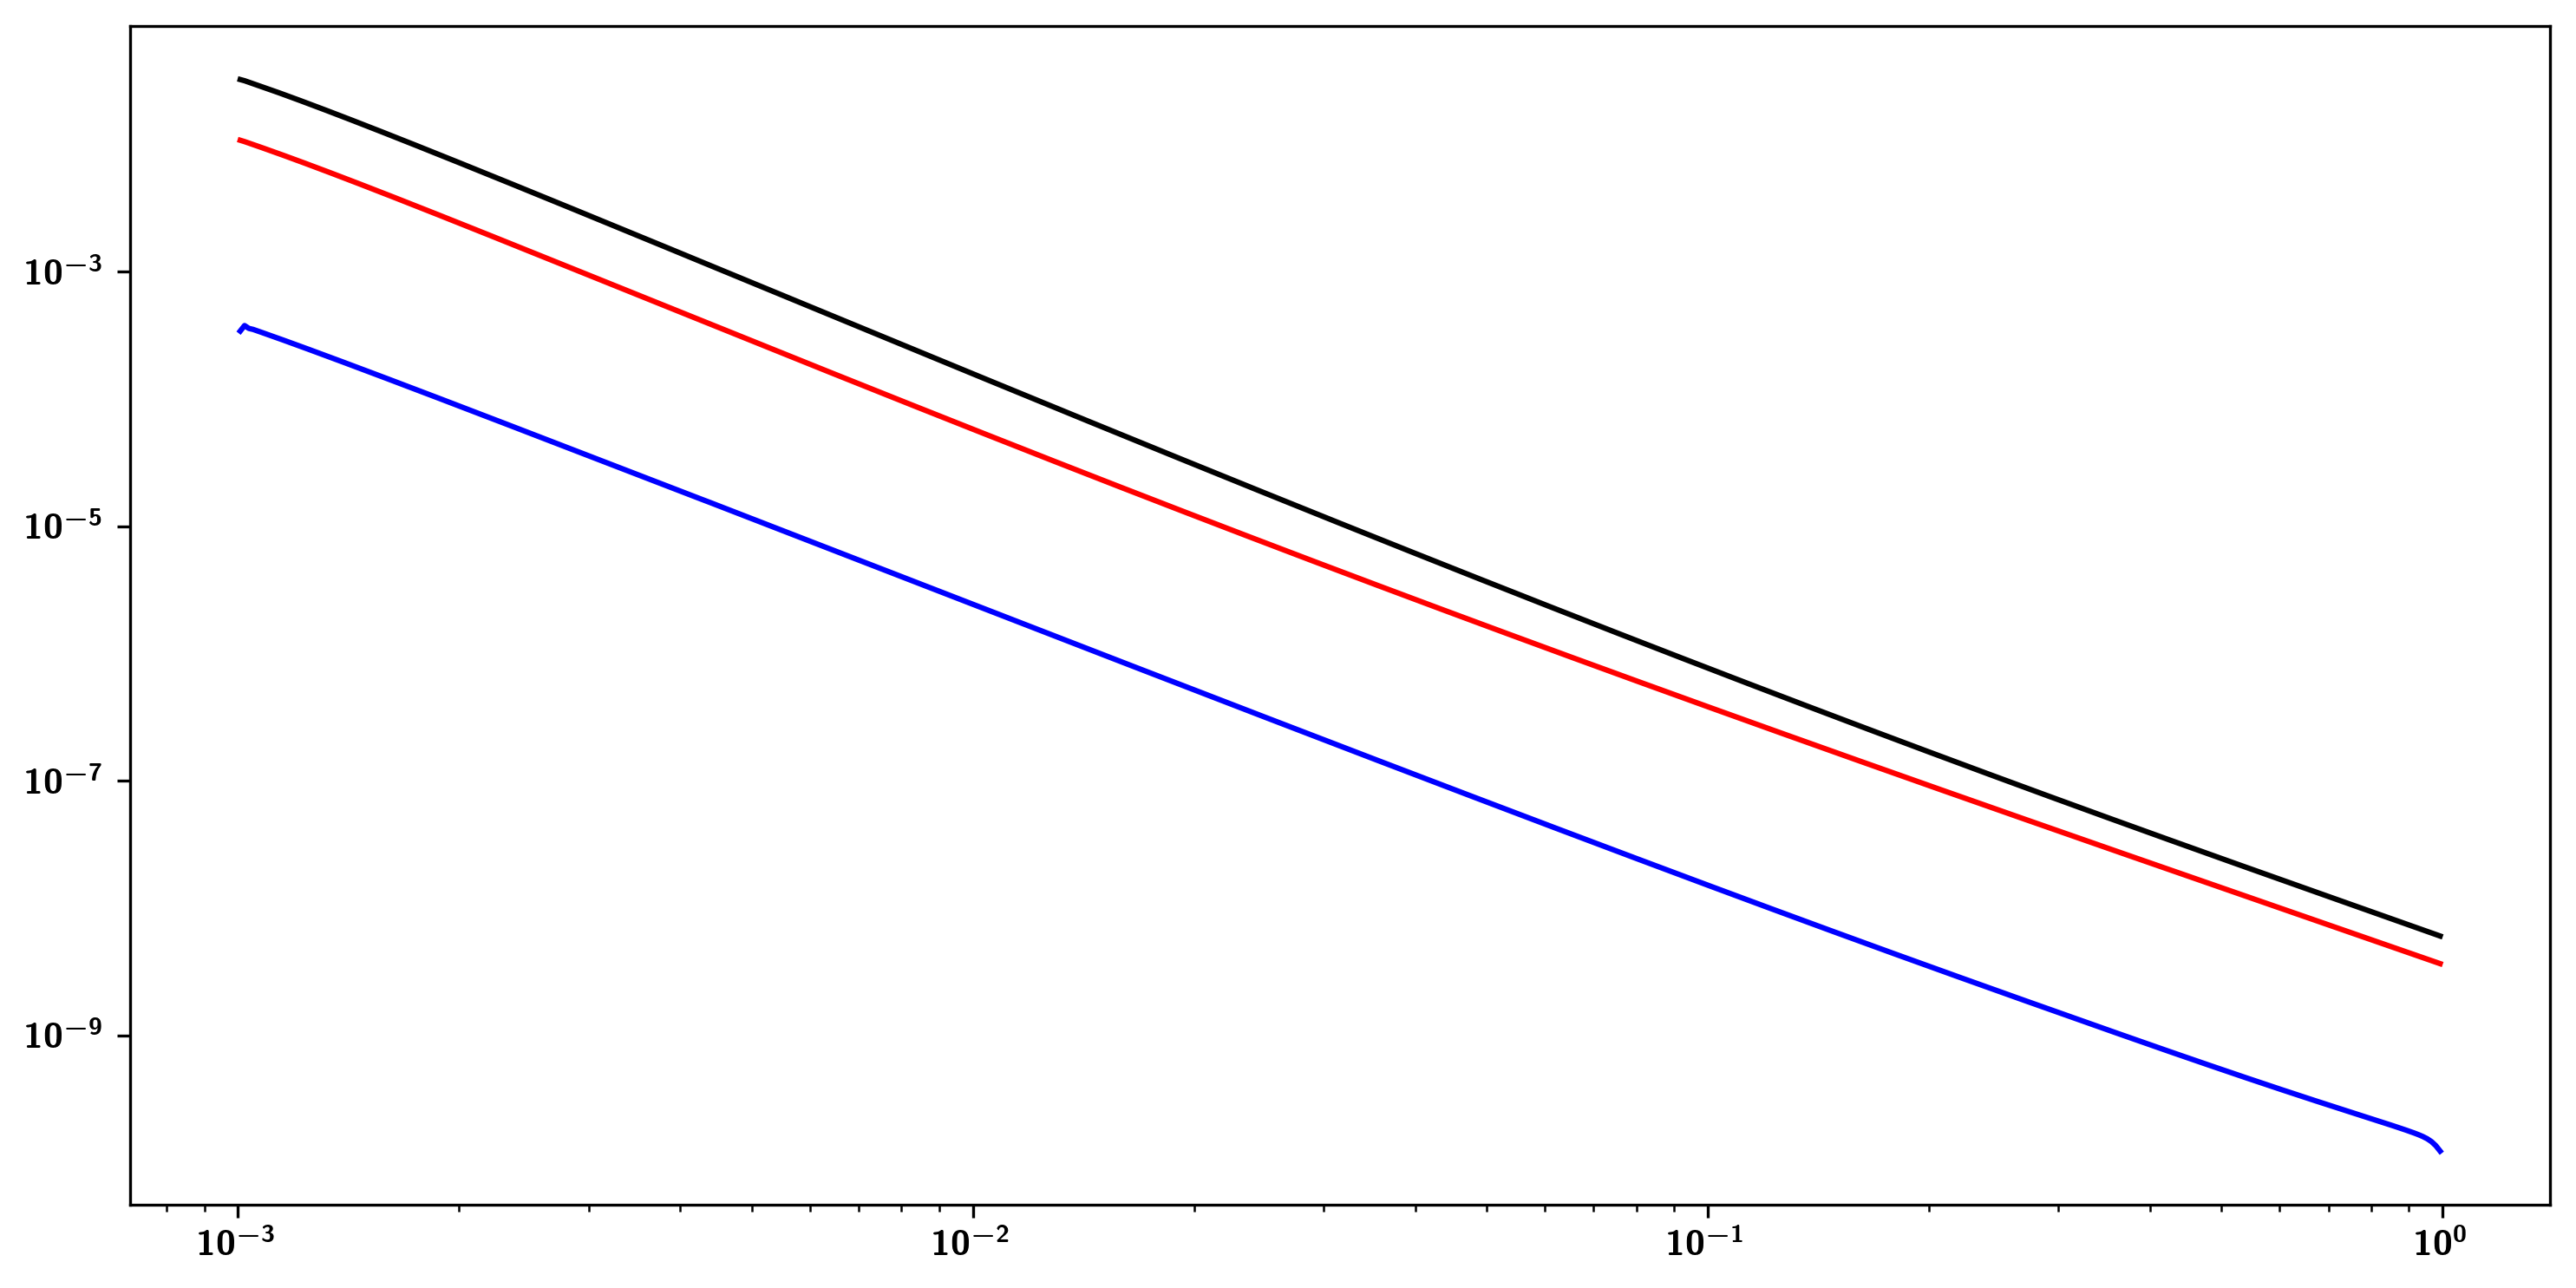

In [16]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,Prat*er_profile,color='black')
axes.plot(x1v,Prat*pr_profile,color='red')
axes.plot(x1v,pg,color='blue')
axes.set_xscale('log')
axes.set_yscale('log')

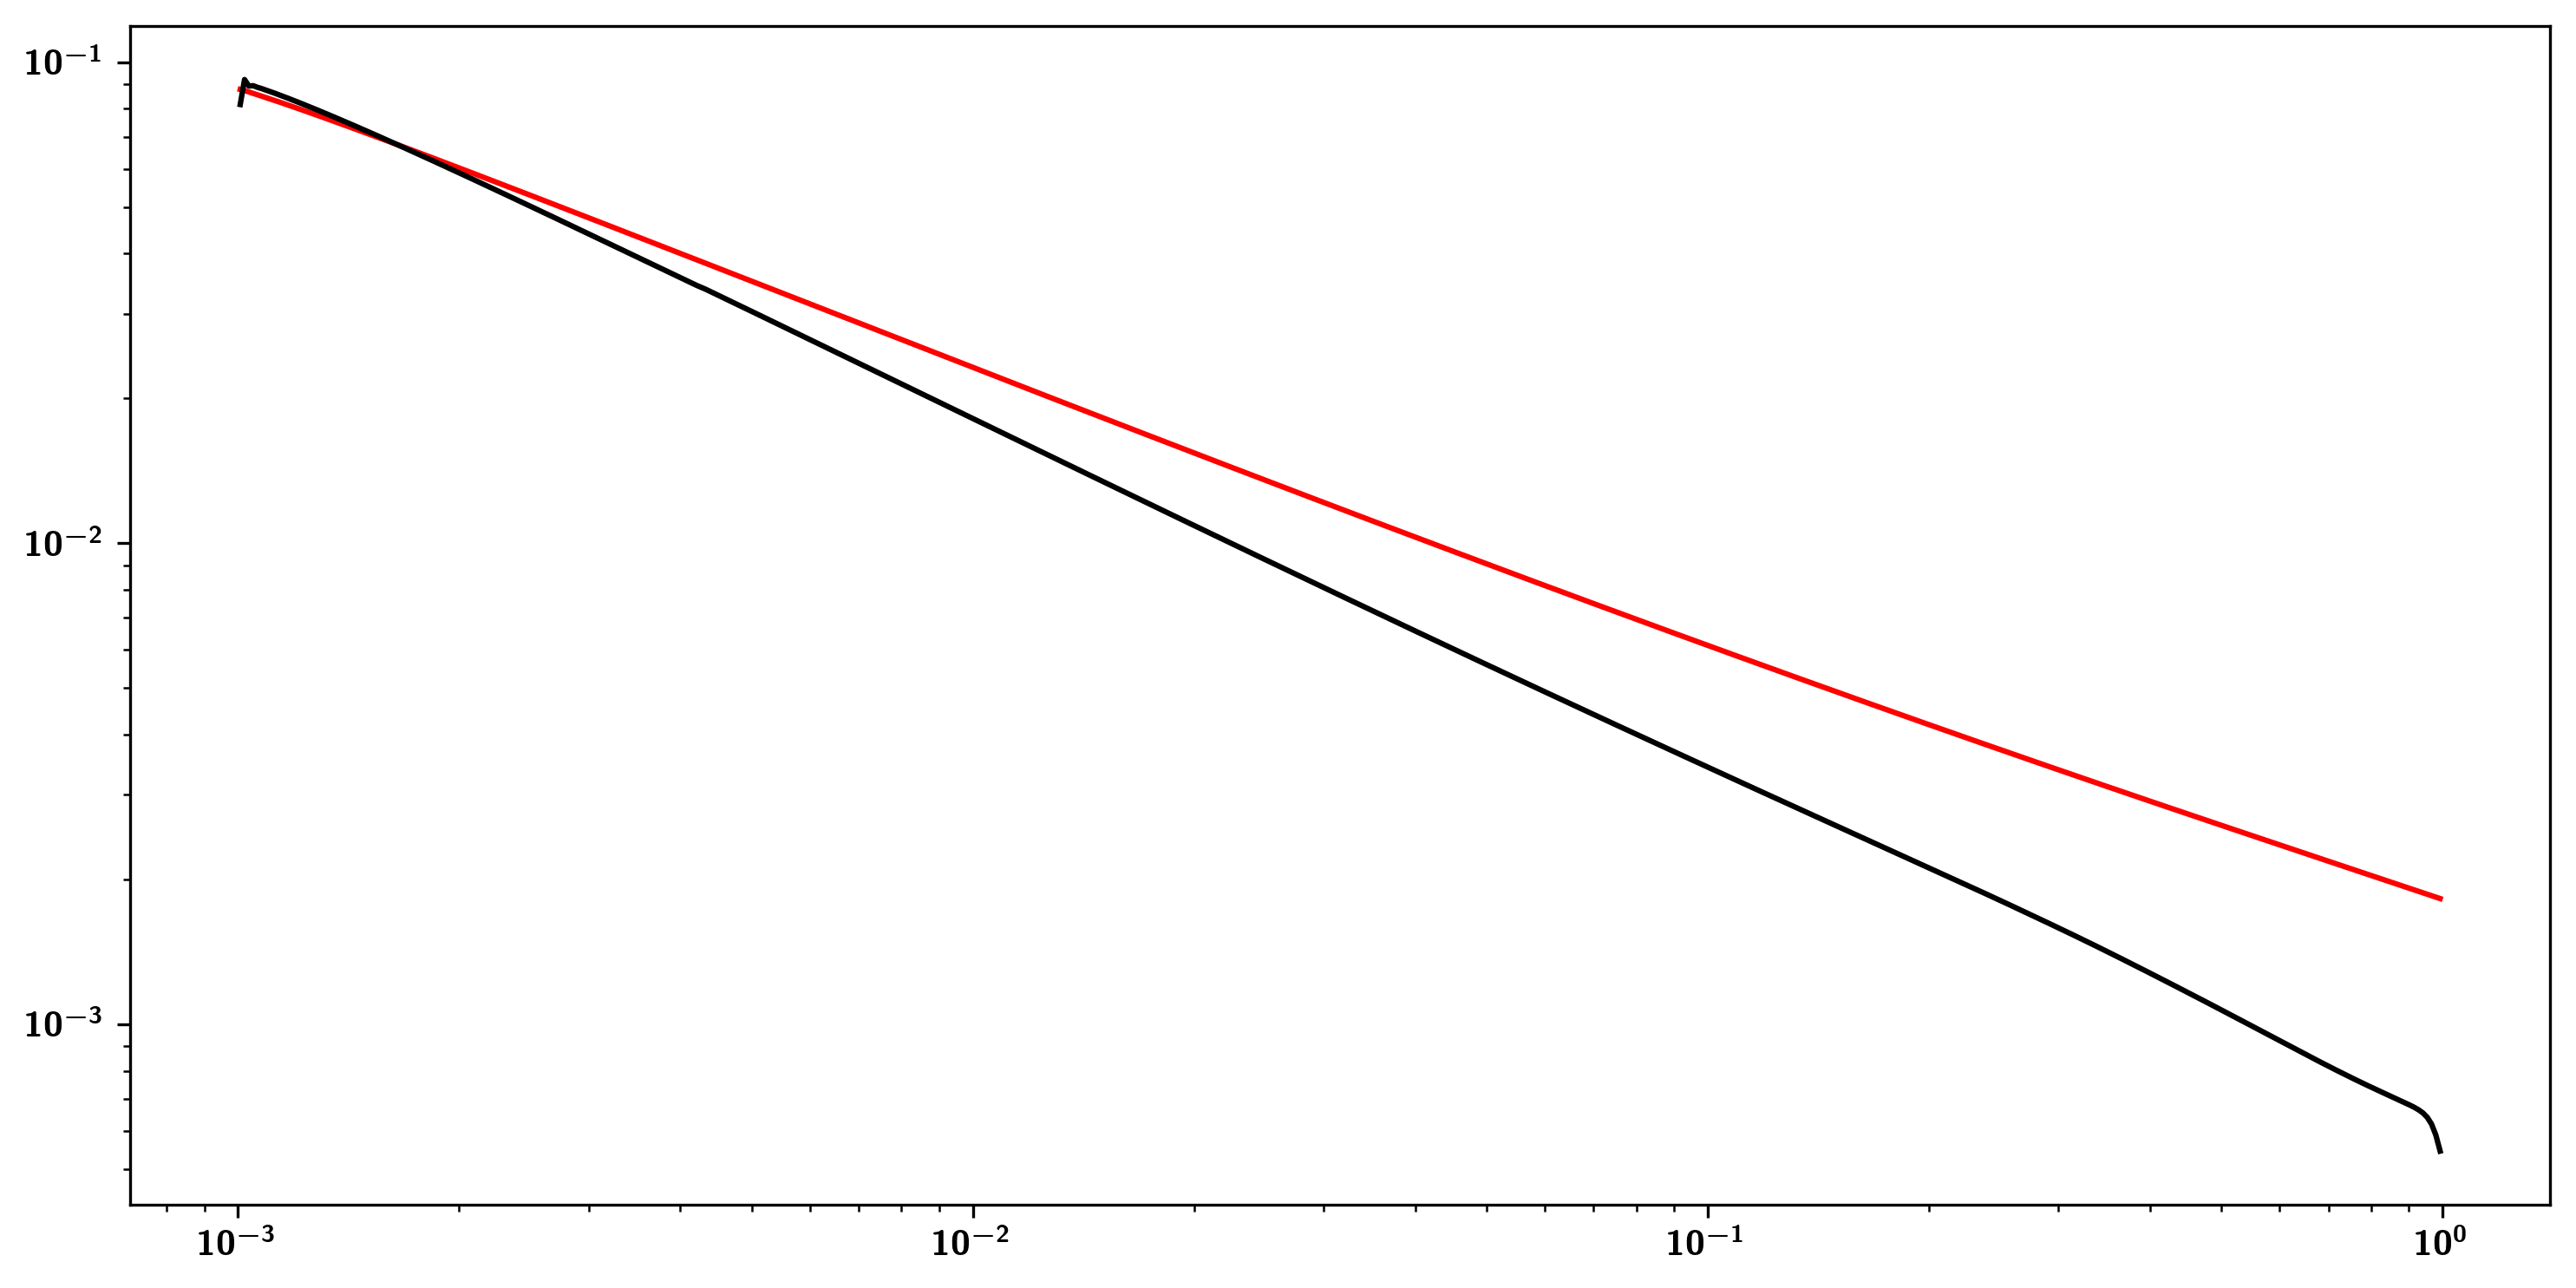

In [72]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,er_profile**0.25,color='red')
axes.plot(x1v,pg/rho,color='black')
axes.set_xscale('log')
axes.set_yscale('log')

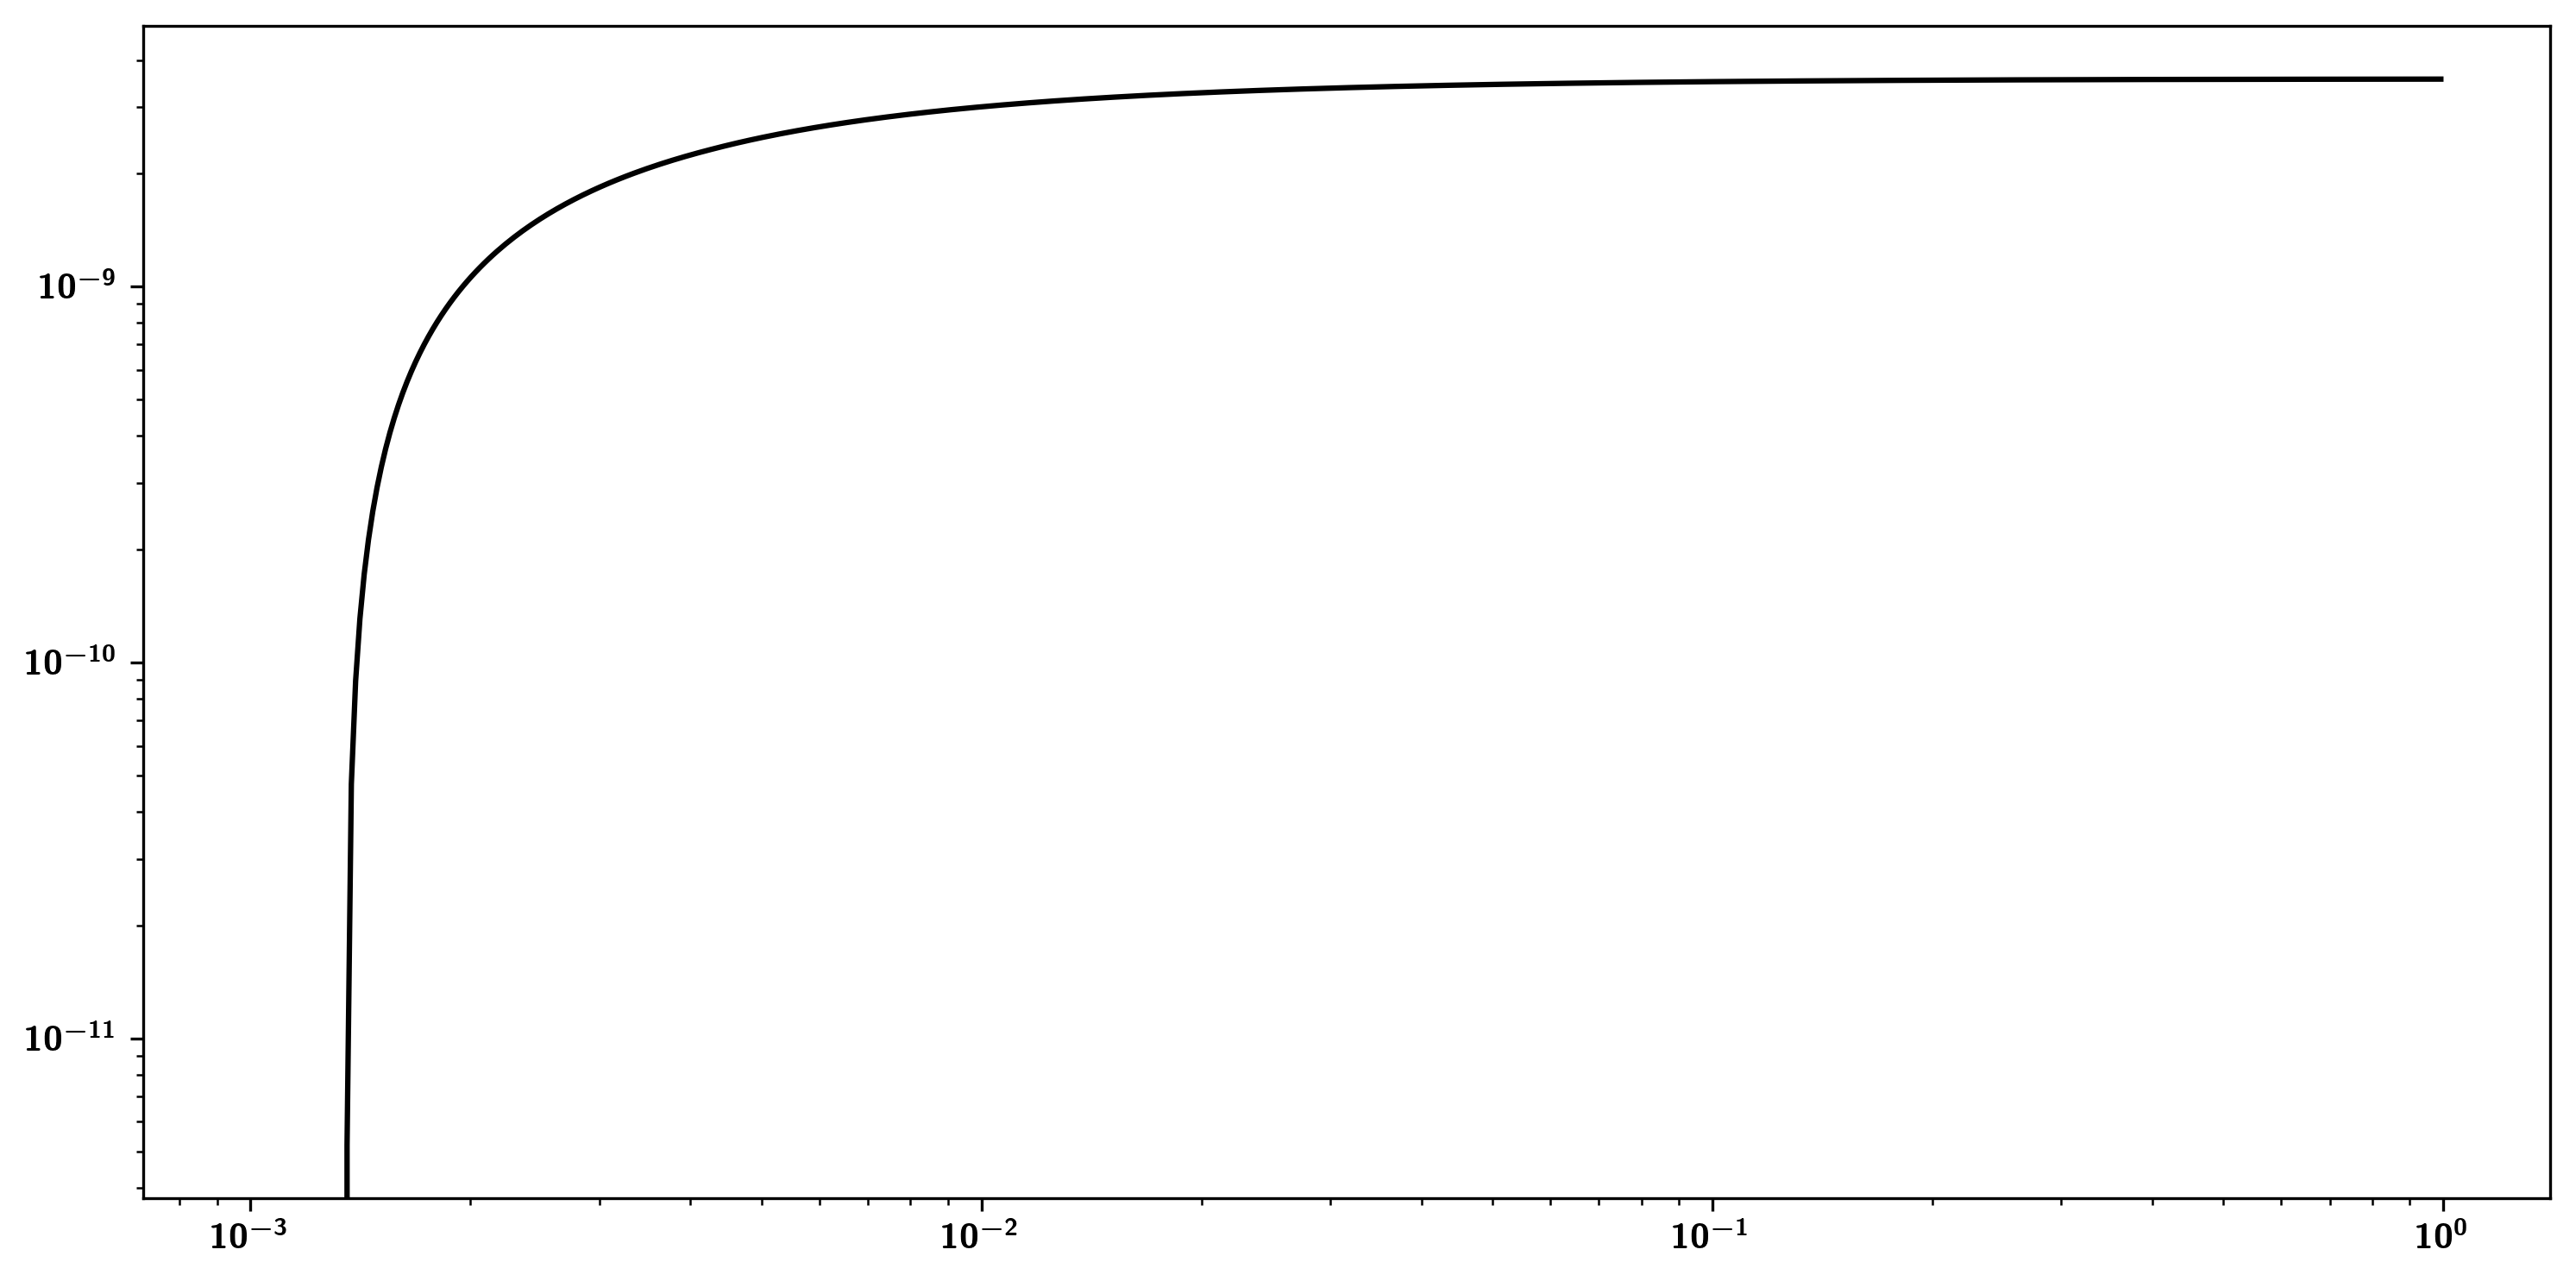

In [17]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,Prat*fr_profile*x1v**2,color='black')
axes.set_xscale('log')
axes.set_yscale('log')

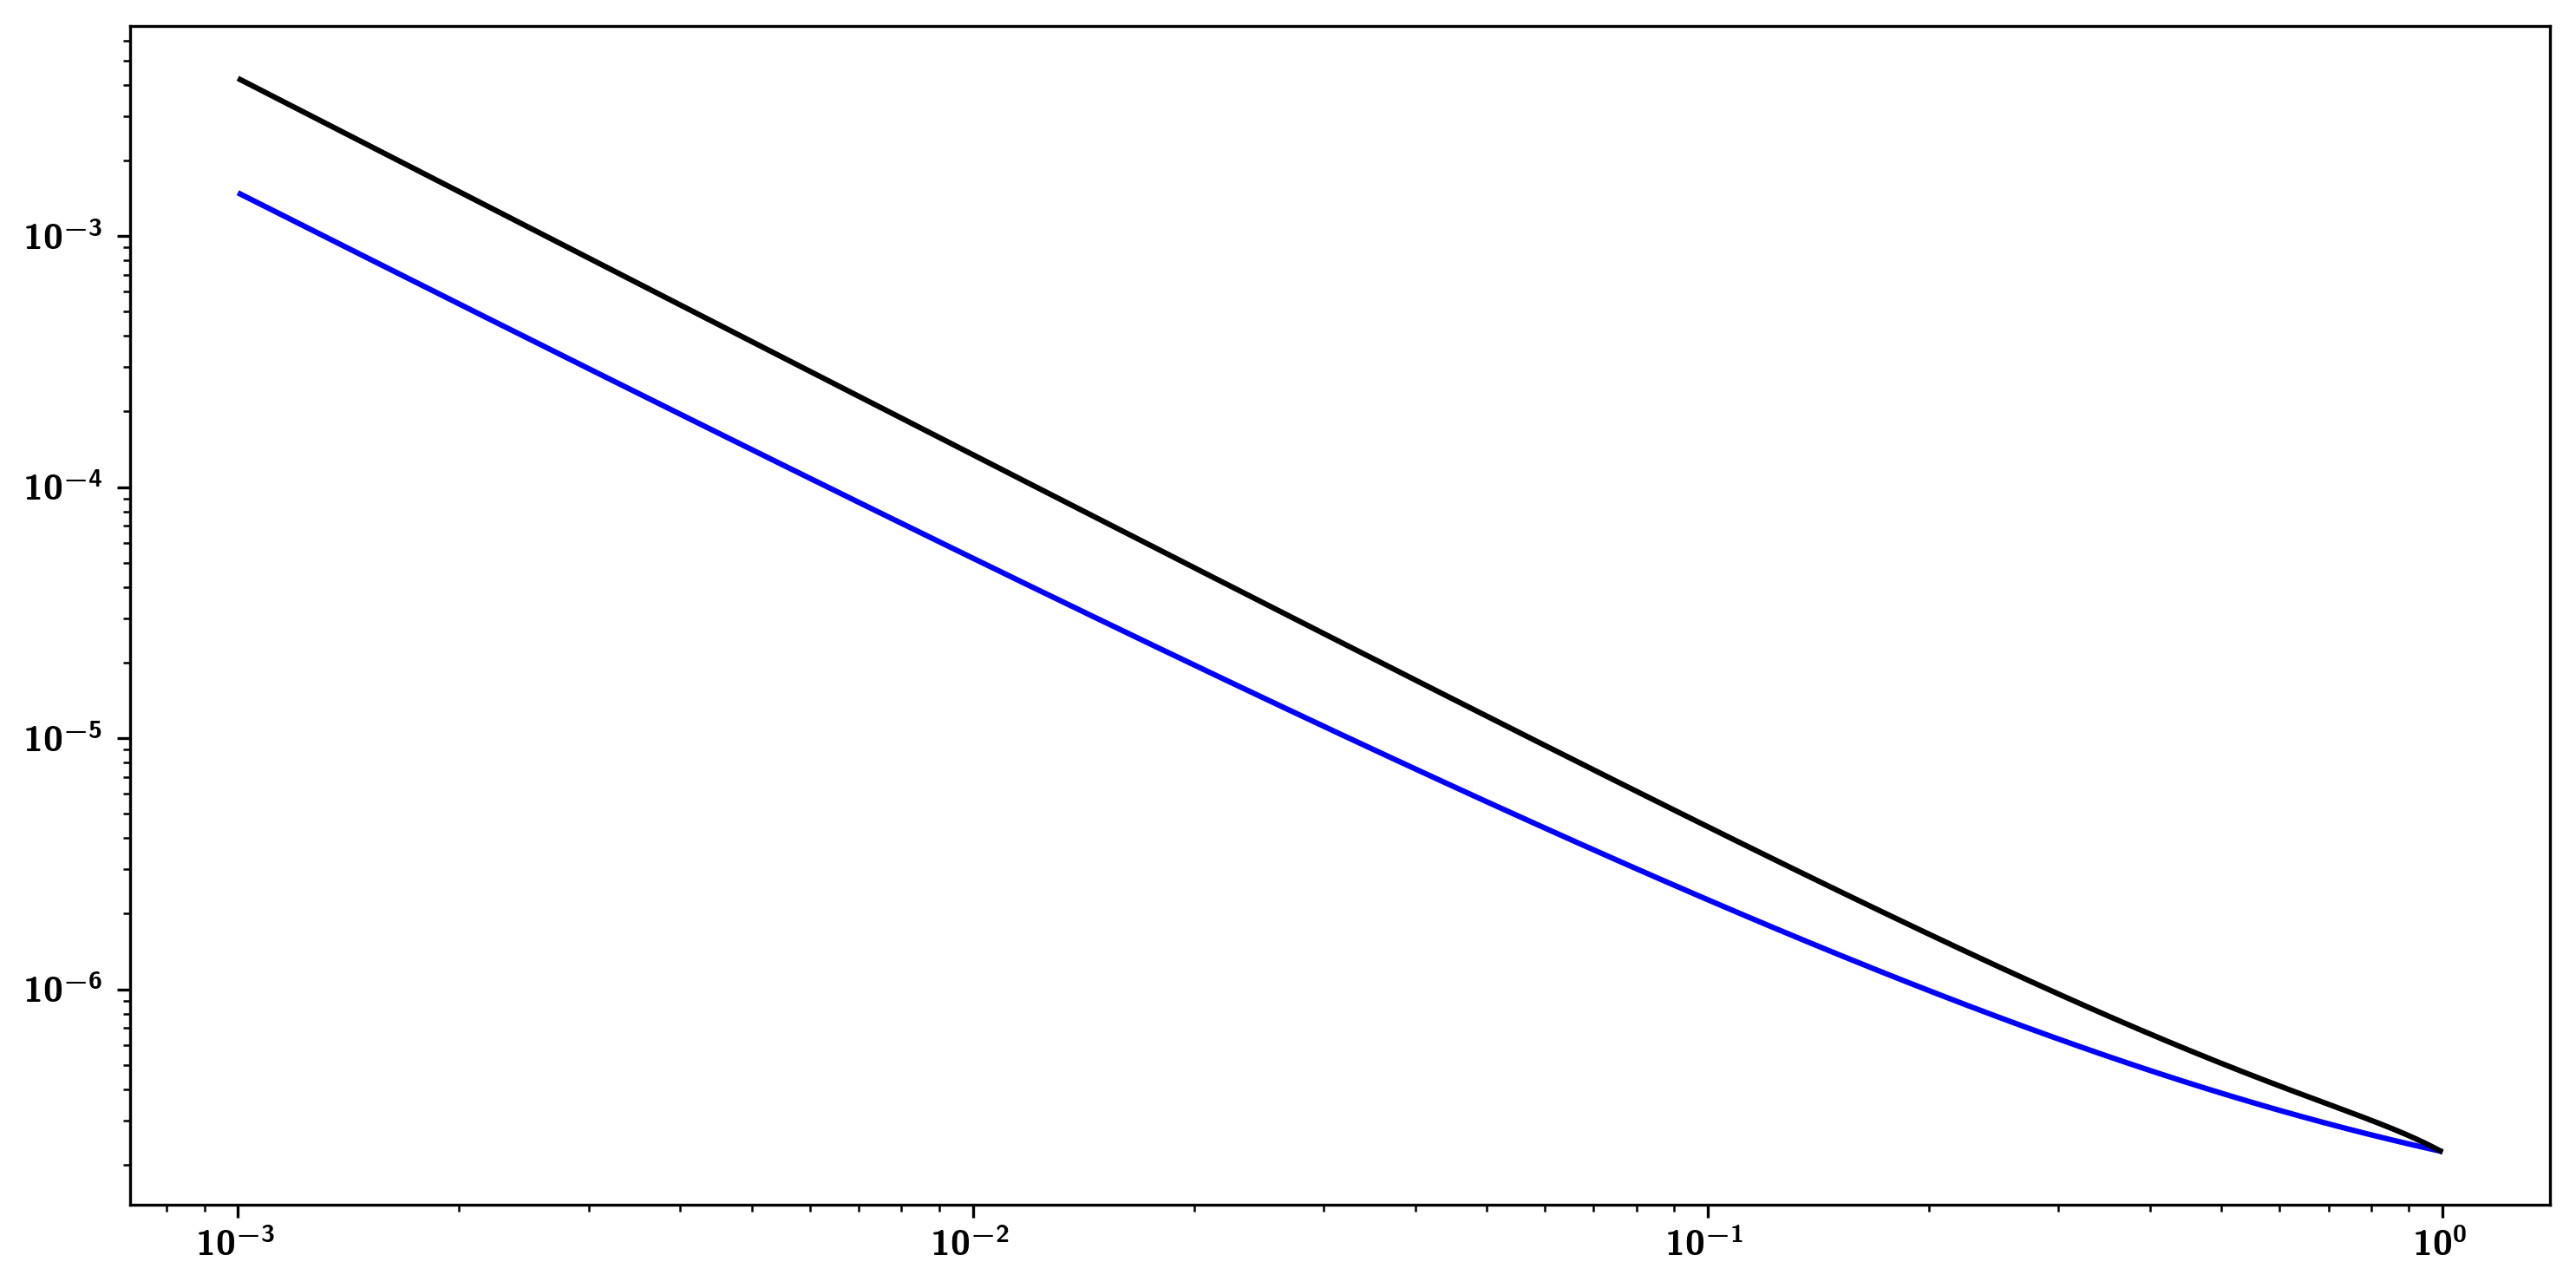

In [18]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,rho0,color='blue')
axes.plot(x1v,rho,color='black')
axes.set_xscale('log')
axes.set_yscale('log')

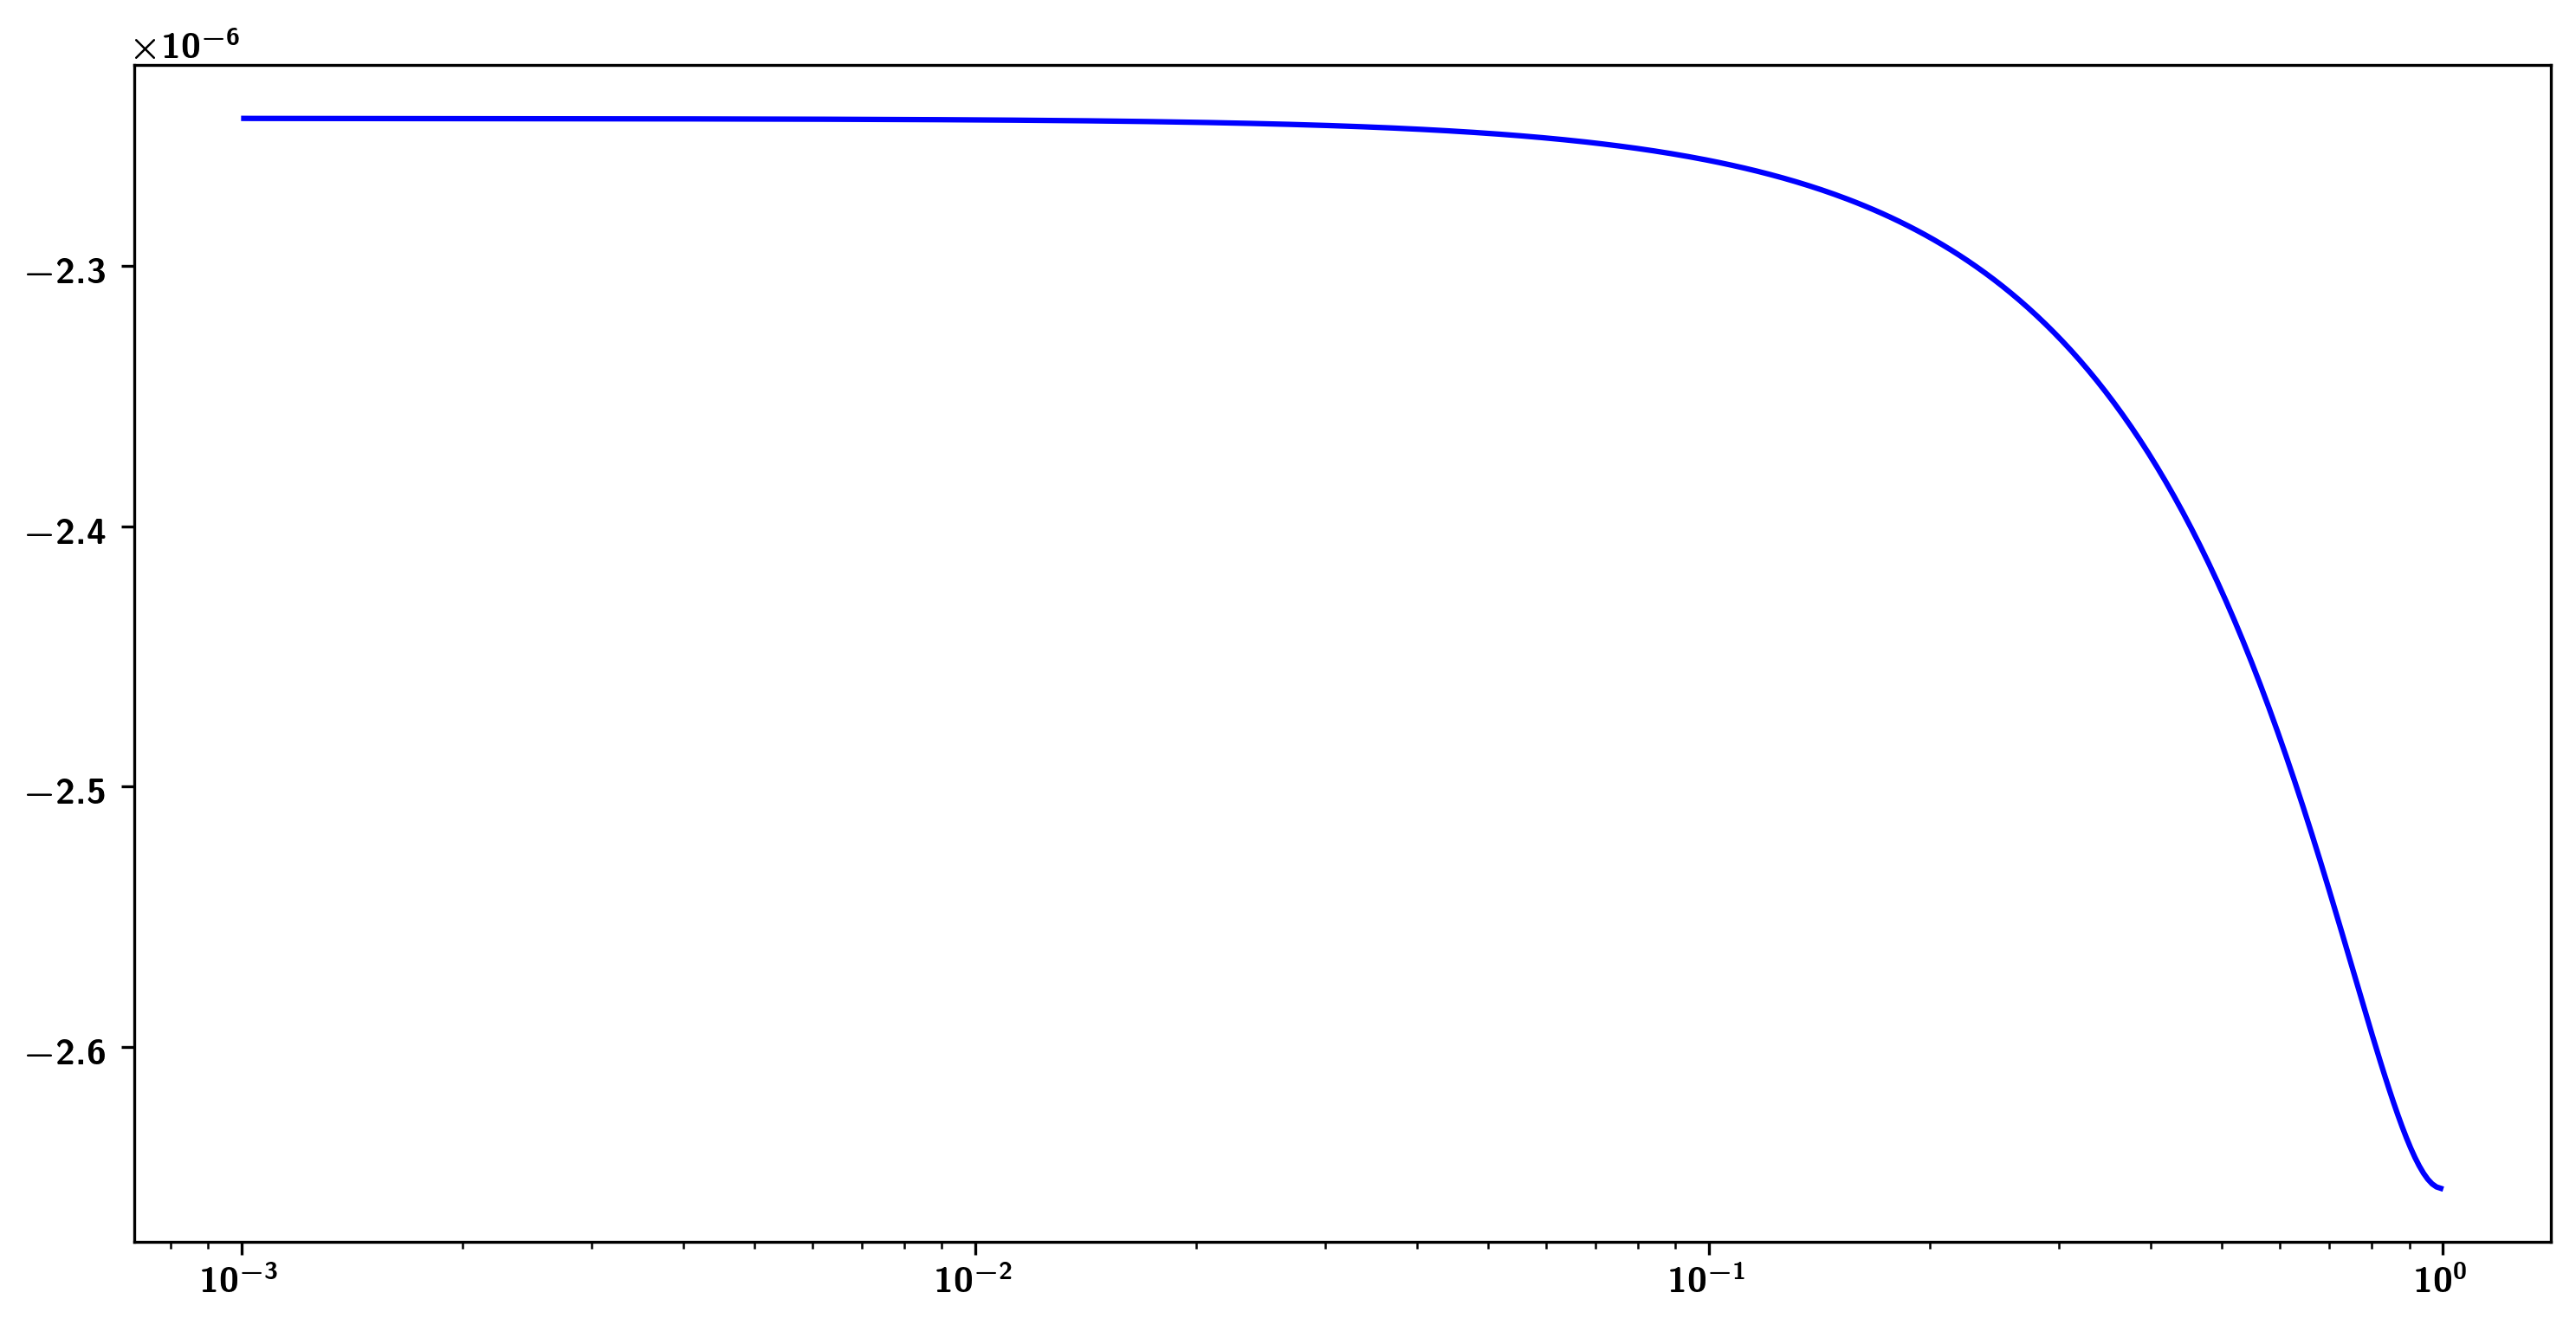

In [19]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,rho*vx*x1v**2,color='blue')
axes.set_xscale('log')

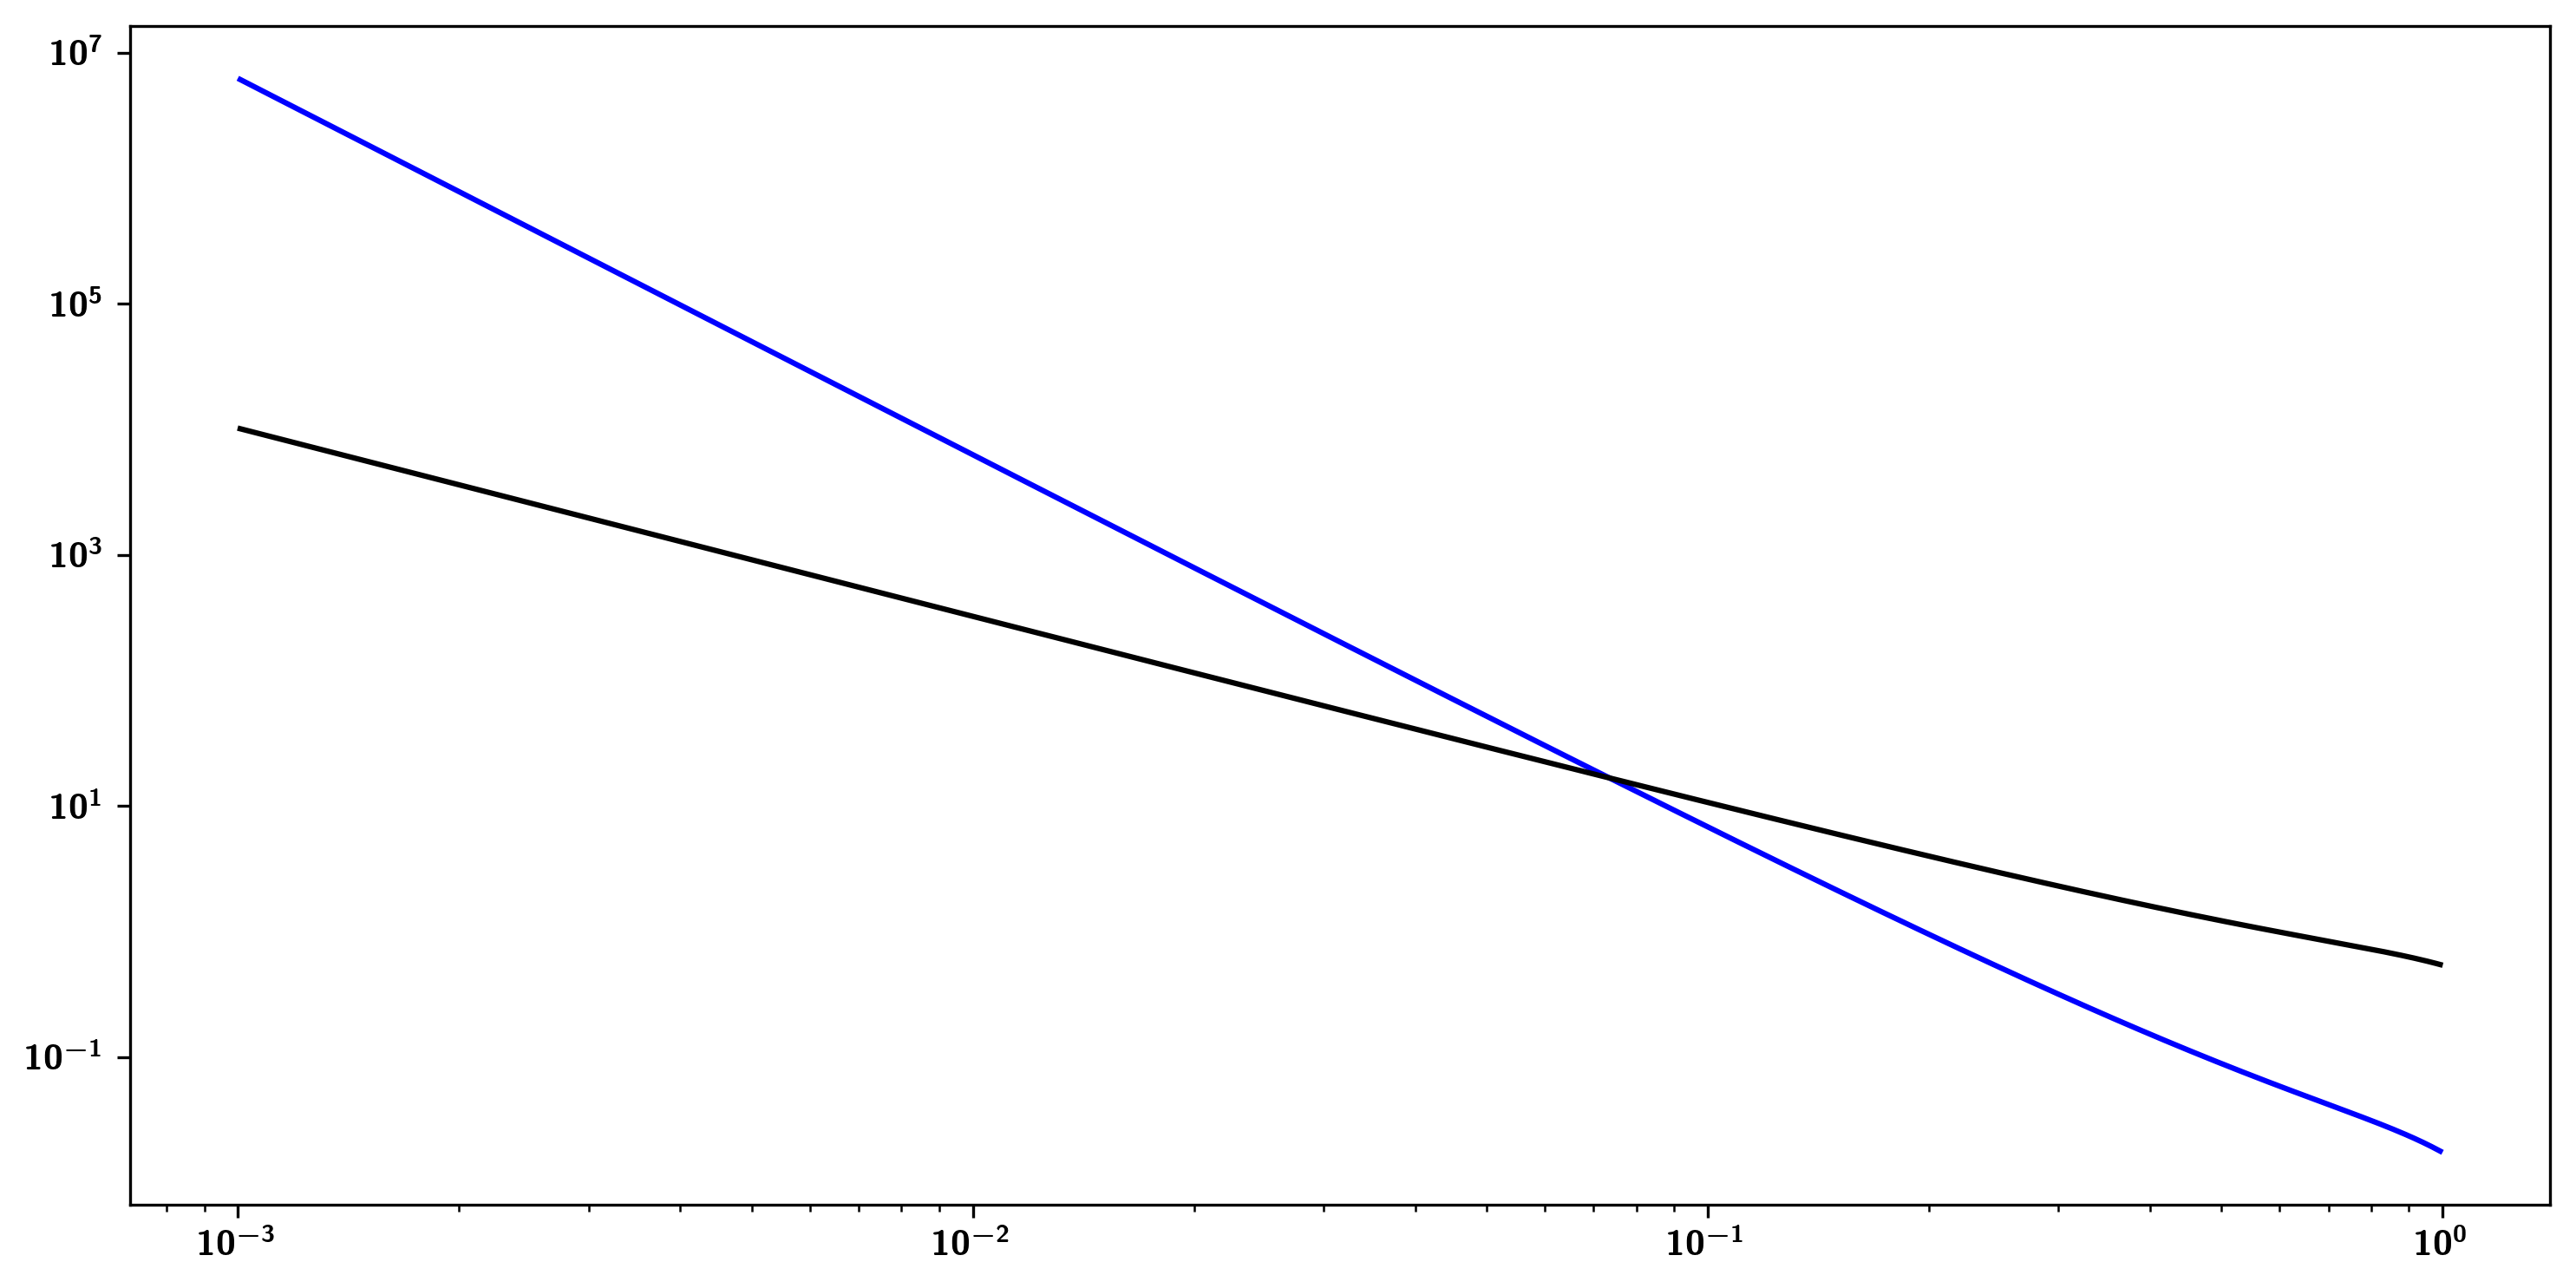

In [20]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,sigma_a_profile,color='blue')
axes.plot(x1v,sigma_s_profile,color='black')
axes.set_yscale('log')
axes.set_xscale('log')

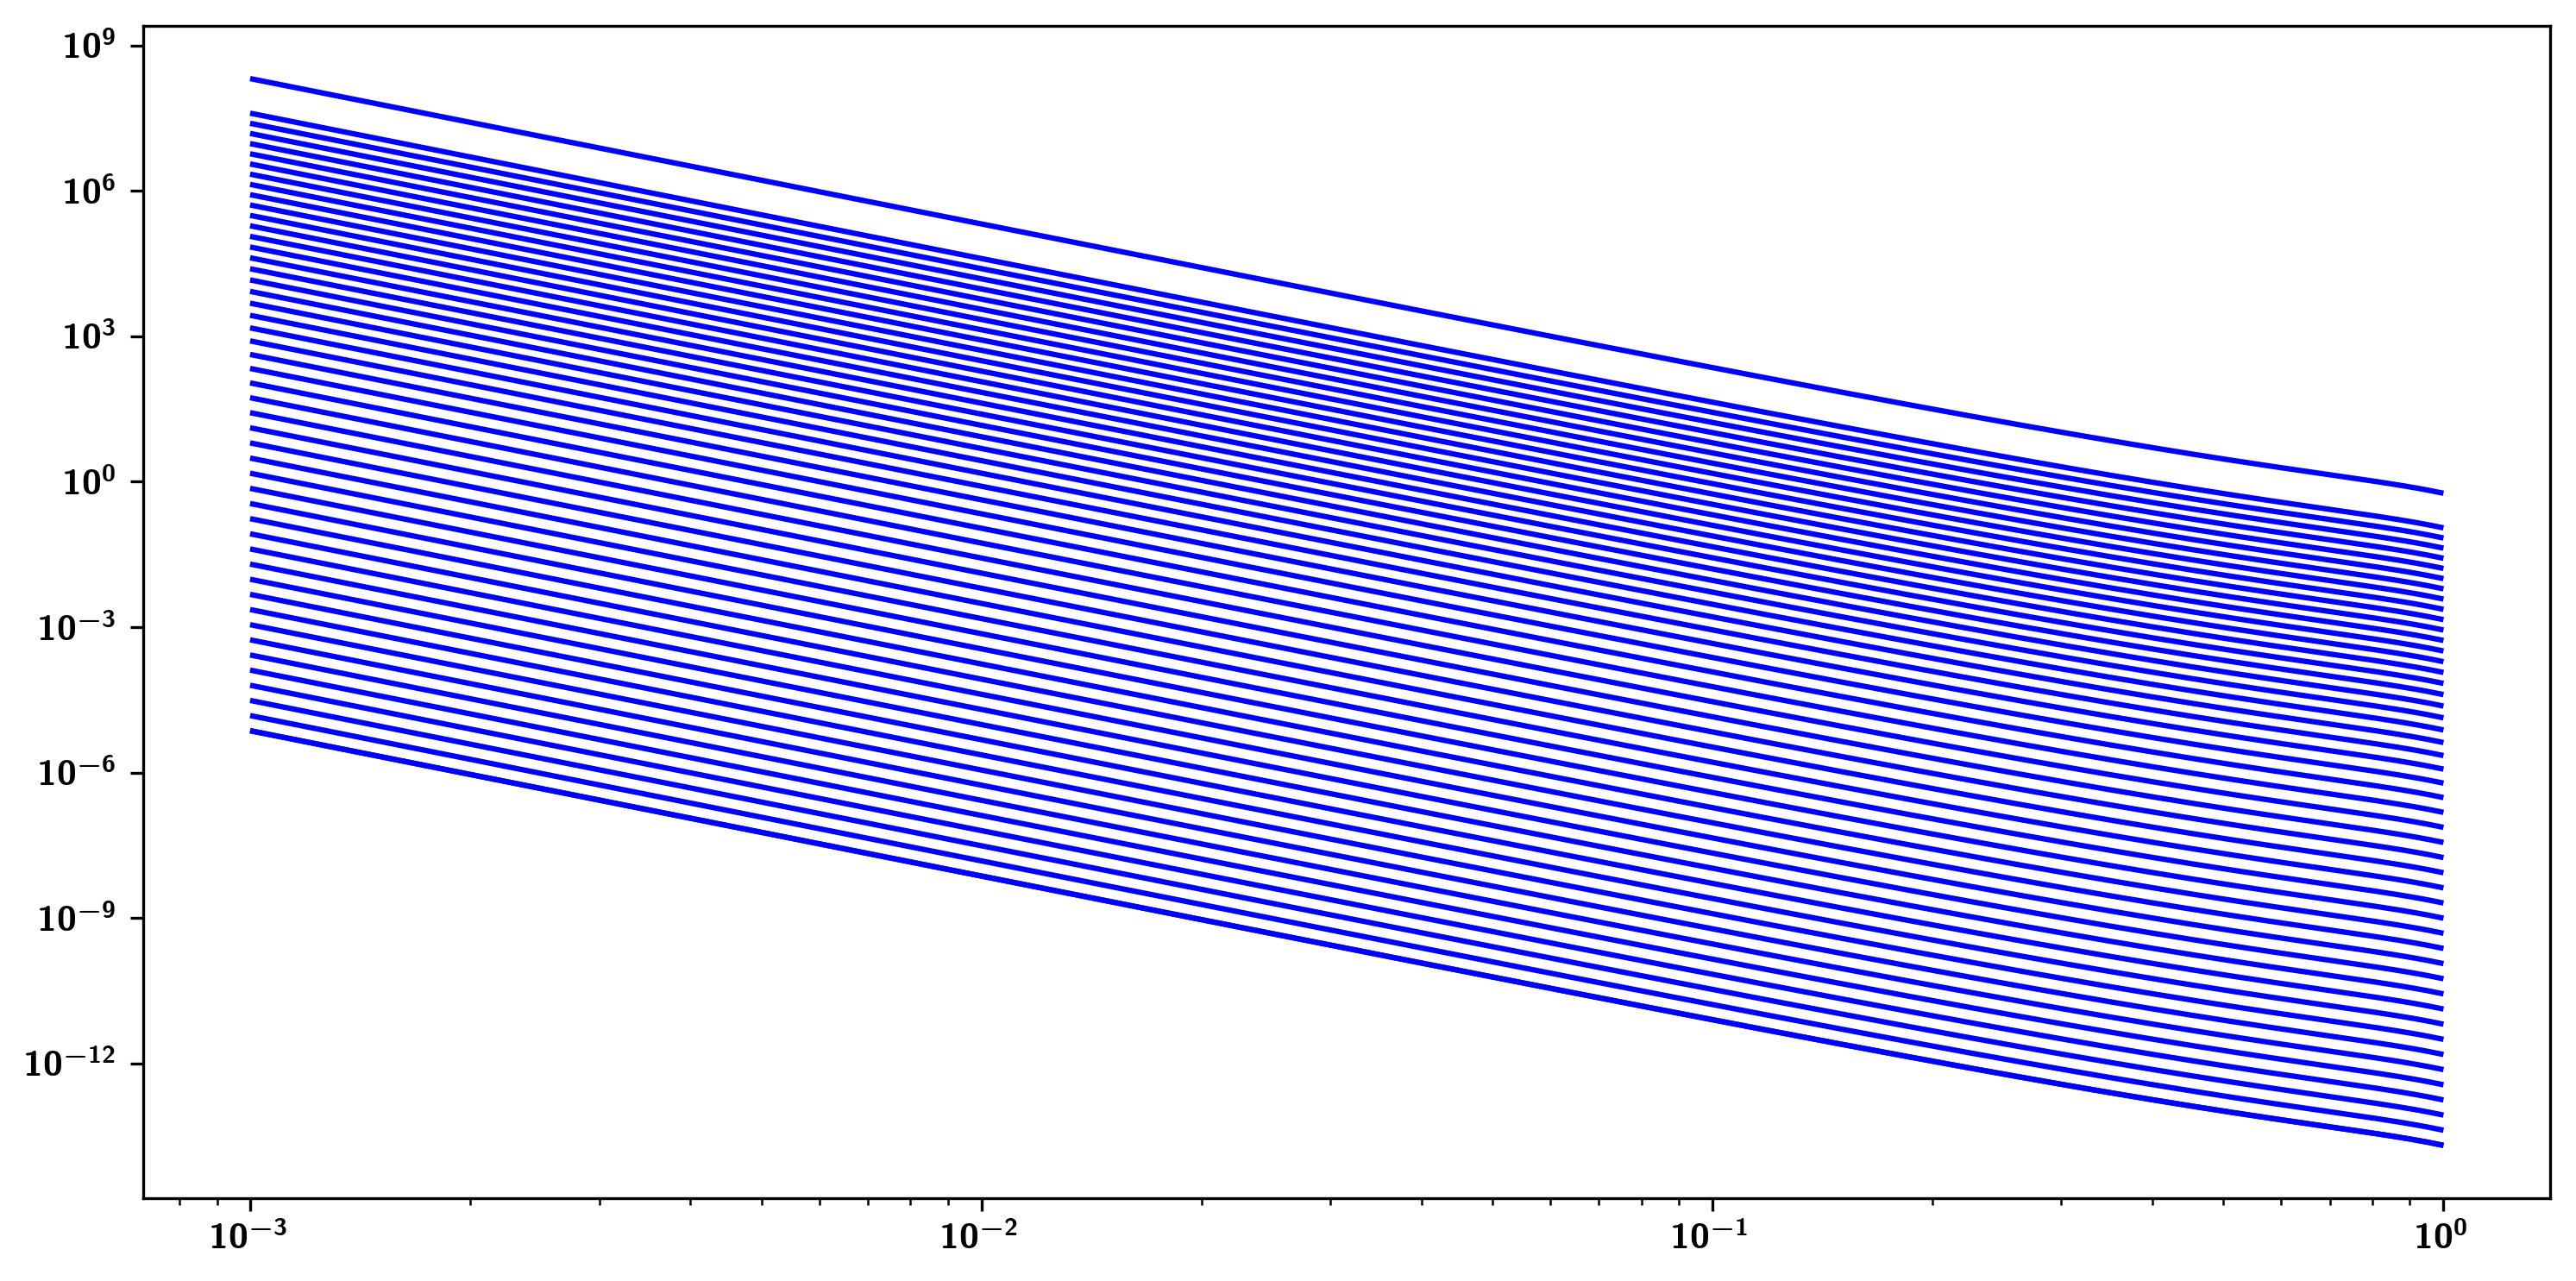

In [75]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,sigma_a,color='blue')
axes.set_yscale('log')
axes.set_xscale('log')

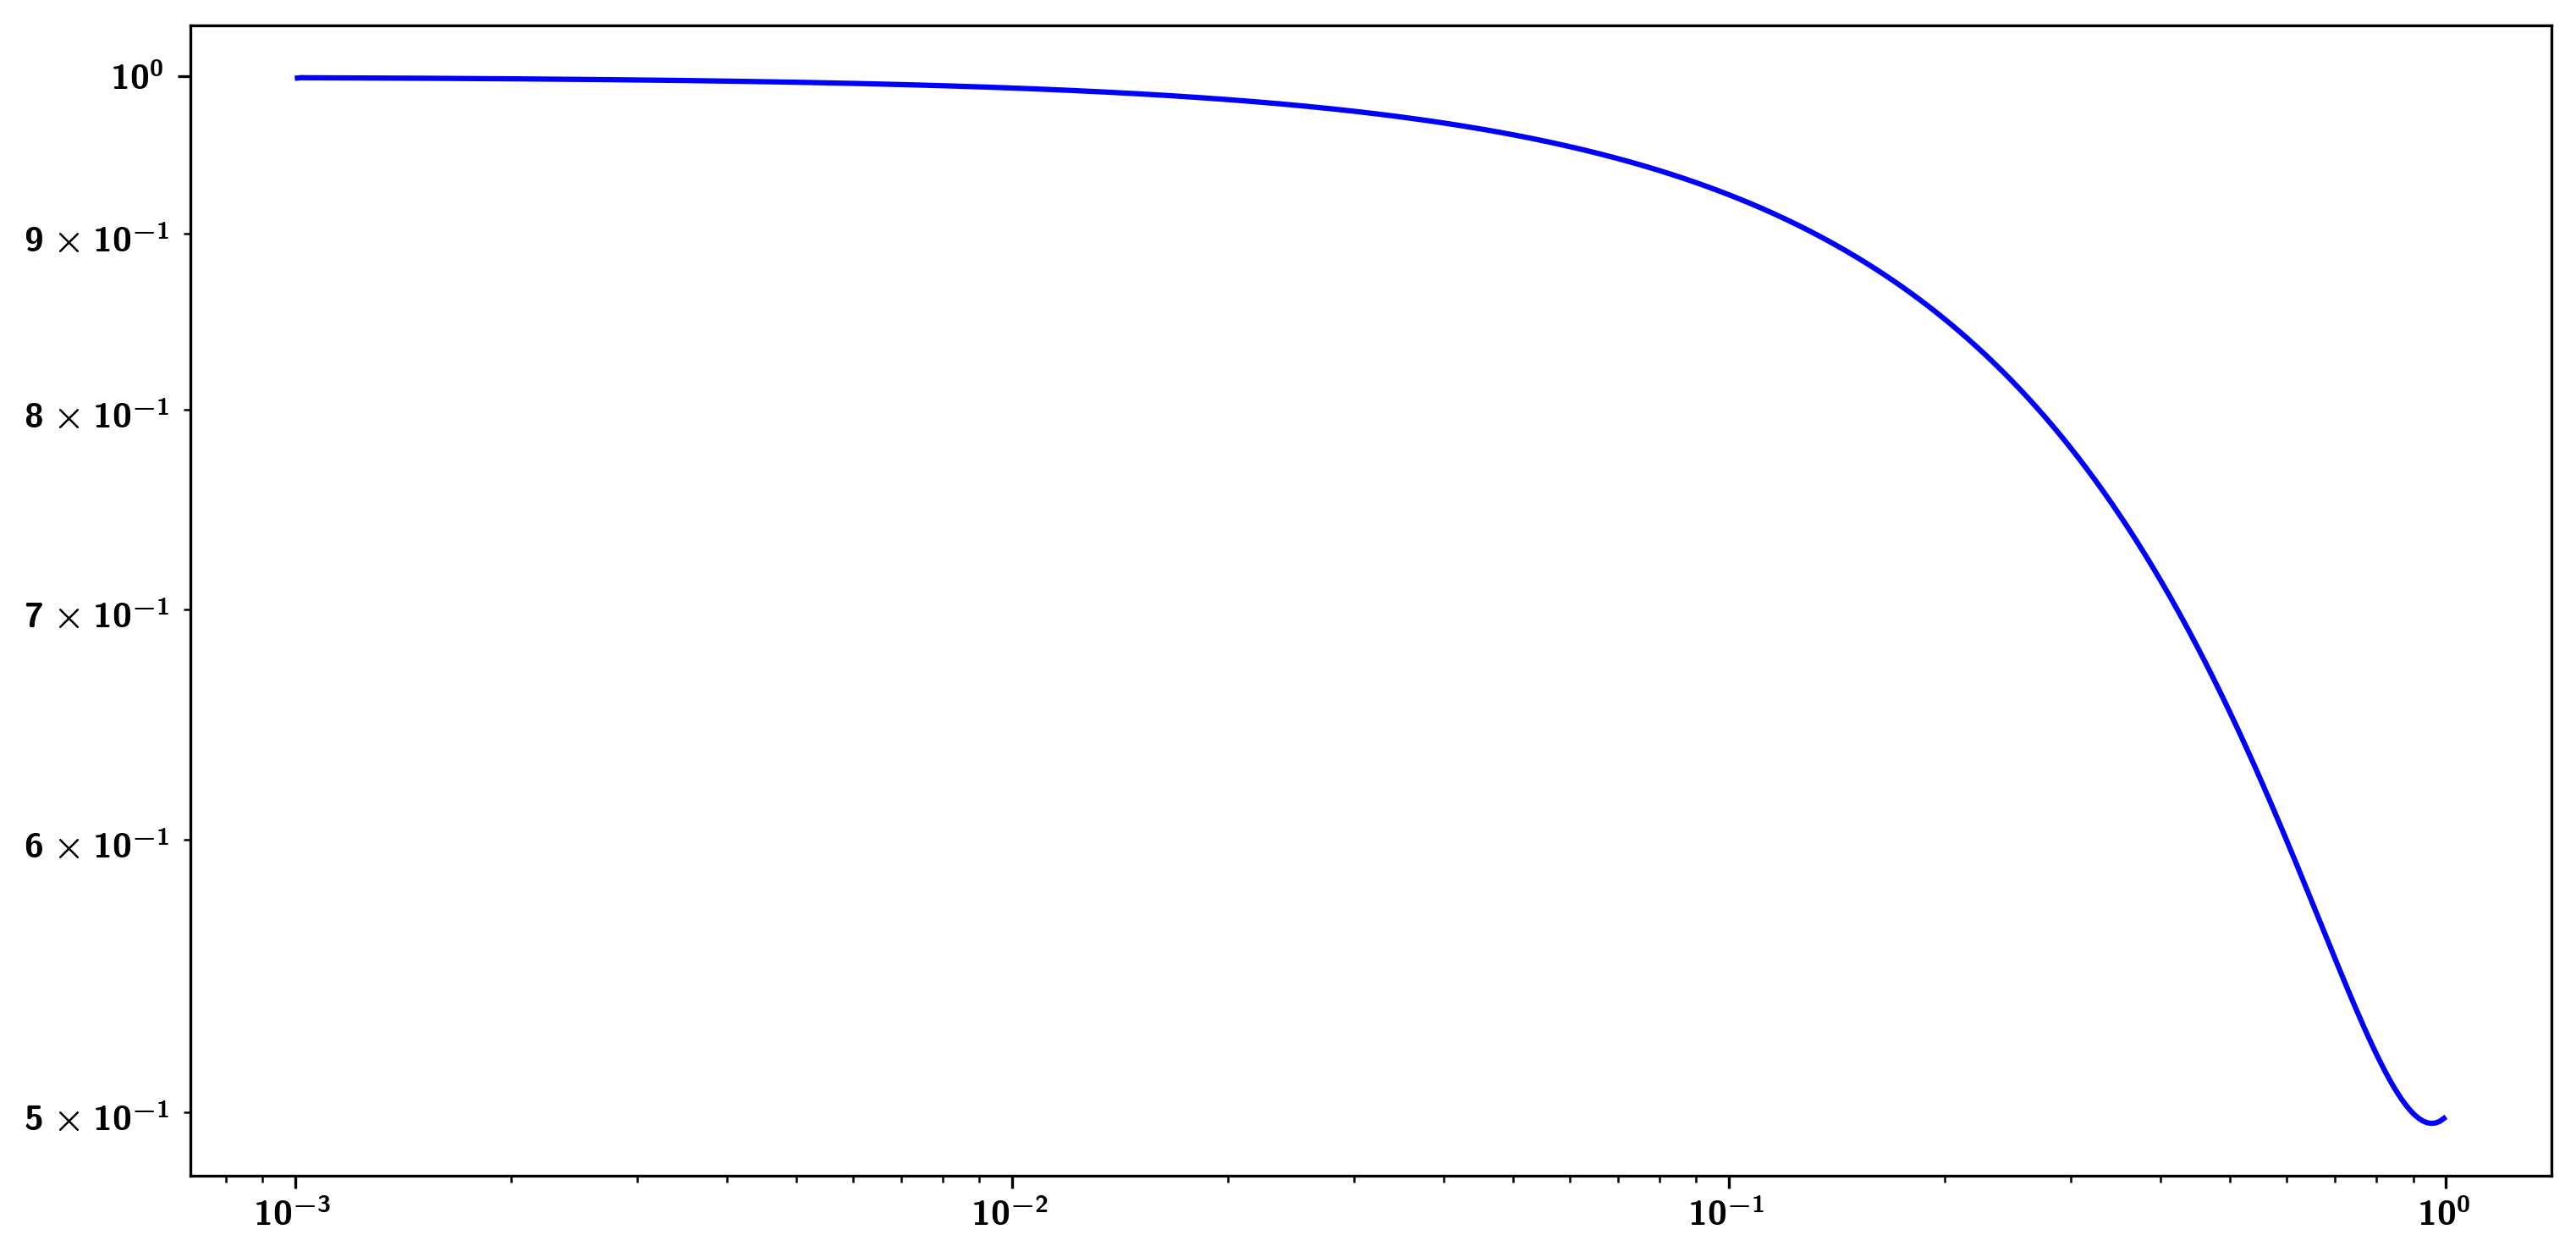

In [21]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.plot(x1v,0.5*vx**2*x1v/gm,color='blue')
#axes.plot(x1v,gm/x1v,color='black')
axes.set_yscale('log')
axes.set_xscale('log')

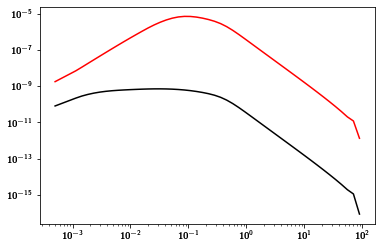

In [69]:
plt.plot(nu_center,specific_er[n_bd,:],color='black')
plt.plot(nu_center,specific_er[100,:],color='red')
plt.xscale('log')
plt.yscale('log')

In [37]:
log_nu=np.log10(nu_center)
log_intensity=np.log10(specific_er[200,:])
print(log_nu)
print(log_intensity)
(log_intensity[-6]-log_intensity[-12])/(log_nu[-6]-log_nu[-12])

[-3.30103    -2.94480101 -2.84063436 -2.73646772 -2.63230107 -2.5281344
 -2.42396772 -2.31980105 -2.21563437 -2.11146771 -2.00730109 -1.90313446
 -1.79896781 -1.69480109 -1.59063436 -1.48646772 -1.38230105 -1.27813438
 -1.17396772 -1.06980104 -0.9656343  -0.86146758 -0.75730096 -0.65313439
 -0.54896771 -0.44480104 -0.34063438 -0.23646771 -0.13230105 -0.02813431
  0.07603226  0.18019887  0.28436564  0.38853235  0.49269901  0.59686567
  0.7010323   0.80519896  0.90936564  1.0135323   1.11769891  1.22186564
  1.32603236  1.43019902  1.53436566  1.63853228  1.74269894  1.84686562
  1.95103229]
[ -9.17719279  -8.58884509  -8.38835824  -8.18654973  -7.98678922
  -7.78967851  -7.59556504  -7.40469232  -7.2221922   -7.05403292
  -6.90152927  -6.7686082   -6.65957694  -6.57672176  -6.52010021
  -6.48854995  -6.47923787  -6.48764242  -6.50942069  -6.54099239
  -6.58071123  -6.62894576  -6.68628262  -6.75526736  -6.8427855
  -6.95991489  -7.11584301  -7.30925544  -7.53030618  -7.7669196
  -8.0099

-2.4263677398886285

### plt.show()

In [24]:
##Plot density, pressure, velocity for comparison

In [44]:
dataplot=[x1v,rho,pg,Prat*pr_profile,vx]
dataplot0=[x1v,rho0,pg0,Prat*pr_profile0,vx0]
filename='bondi1d.pdf'
ylabel1='$\\rho/\\rho_0$'
ylabel2='$P_g,P_r/P_0$'
ylabel3='-$v_r, c_s/v_0$'

In [45]:
PlotProfile5(dataplot,filename,ylabel1,ylabel2,ylabel3,xlimit=[1.e-3,0.5],xlabel='$r/r_B$',data0=dataplot0,
             ylimi2=[1.e-10,1.e2],xline=x1v[n_bd_fr])

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_5726/1391235010.py:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.clf()


In [95]:
print(np.mean(rho*vx*x1v**2)/np.mean(rho0*vx0*x1v**2))

3.1144295


In [153]:
nu_fit=np.arange(-4,2,0.001)
nu_fit=10**nu_fit

In [ ]:
##Now plot the spectrum

In [101]:
print(specific_er[5,:]/er_profile[5])
print(nu_center[29])

[8.41823985e-05 3.43005527e-04 5.36967205e-04 8.68955846e-04
 1.39923459e-03 2.25285675e-03 3.62335450e-03 5.82042645e-03
 9.33478854e-03 1.49403162e-02 2.38490864e-02 3.79380485e-02
 6.00866264e-02 9.46246986e-02 1.47933903e-01 2.29041800e-01
 3.50228282e-01 5.30253826e-01 7.91780371e-01 1.14303936e+00
 1.56315758e+00 1.98481743e+00 2.28480305e+00 2.29924486e+00
 1.98649173e+00 1.46676793e+00 9.38847500e-01 5.46088430e-01
 3.05112630e-01 1.70162582e-01 9.58924843e-02 5.44649078e-02
 3.10407447e-02 1.77048875e-02 1.00706134e-02 5.74452733e-03
 3.27585019e-03 1.86331532e-03 1.05631570e-03 5.96240881e-04
 3.34658746e-04 1.86440767e-04 1.02855140e-04 5.59624931e-05
 2.99319134e-05 1.56010375e-05 7.75022004e-06 4.75591433e-06
 6.18411633e-07]
0.9372720999999999


In [85]:
np.abs(x1v-0.2).argmin()

392

In [62]:
x1v[10]

0.0011524558

In [109]:
## curve fitting
def powerlaw(x, a, b):
    return a * x**b
def blackbody(x,a,b):
    return a*x**3/(np.exp(x/b)-1)

In [94]:
from scipy.optimize import curve_fit

In [107]:
popt, pcov = curve_fit(powerlaw, nu_center[29:-2], specific_er[5,29:-2]/er_profile[5])

In [108]:
print(popt,pcov)

[ 0.14579288 -2.37001172] [[ 1.03303623e-08 -8.11413069e-08]
 [-8.11413069e-08  1.14727489e-05]]


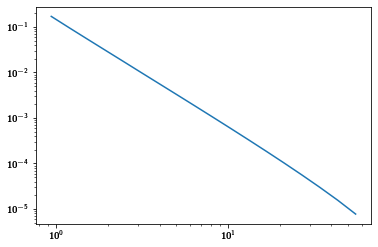

In [106]:
plt.plot(nu_center[29:-2],specific_er[5,29:-2]/er_profile[5])
plt.xscale('log')
plt.yscale('log')

In [113]:
popt2, pcov2 = curve_fit(blackbody, nu_center[:-2], specific_er[5,:-2]/er_profile[5])

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_48996/1520177974.py:5: RuntimeWarning: overflow encountered in exp
  return a*x**3/(np.exp(x/b)-1)


In [114]:
print(popt2,pcov2)

[3.78381430e+03 7.57813736e-02] [[ 1.60563044e+04 -9.44440963e-02]
 [-9.44440963e-02  6.30495335e-07]]


In [154]:
fit_bd=np.zeros(len(nu_fit))

In [155]:
for i in range(len(nu_fit)):
        fit_bd[i]=blackbody(nu_fit[i],popt2[0],popt2[1])

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_48996/1520177974.py:5: RuntimeWarning: overflow encountered in exp
  return a*x**3/(np.exp(x/b)-1)


(1e-05, 10)

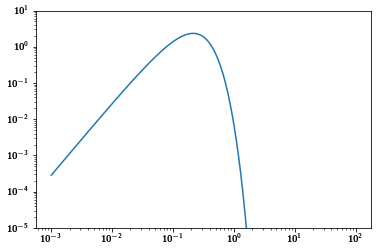

In [130]:
plt.plot(nu_fit,fit_bd)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-5,10])

In [162]:
ylabel='$E_r(\\tilde{\\nu})\\tilde{\\nu_0}/E_r$'
filename='bondi_spectrum.pdf'
xlabel="$\\tilde{\\nu}$"
label2='$r/r_B=0.01$'
label3='$r/r_B=0.0012$'
label4='$y=10$'
text='$\\propto \\tilde{\\nu}^{-2.4}$'
#print(histories[:,0])
PlotProfile(nu_center,specific_er[392,:]/er_profile[392],1.e-4, 100, 1.e-5, 10, ylabel, 
            '$r/r_B=0.2$',filename, xlabel,datax2=nu_center,datay2=specific_er[170,:]/er_profile[170],
            label2=label2,datax3=nu_center,datay3=specific_er[5,:]/er_profile[5],
            label3=label3,logscale=1,xlogscale=1,leg_loc=(0.7,0.25),datax4=nu_fit,datay4=fit_bd,text=text,
           text_loc=[4,0.01])